# Import and settings

In [60]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import logging
import logzero
from logzero import logger


# examination settings
batch_size = 128
test_batch_size = batch_size * 4
momentum = 0.9
seed = 2017
num_workers = 2
use_gpu = False

# set seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# logger setting
LOG_FORMAT = '[%(asctime)s %(levelname)s] %(message)s'
logzero.loglevel(logging.INFO)
logzero.formatter(logging.Formatter(LOG_FORMAT))

# Prepare data

In [61]:
train_dataset = datasets.MNIST('./data/MNIST/train/', download=True, train=True)
test_dataset = datasets.MNIST('./data/MNIST/test/', download=True, train=False)

train_data = train_dataset.train_data.numpy()
test_data = test_dataset.test_data.numpy()
train_labels = train_dataset.train_labels.numpy()
test_labels = test_dataset.test_labels.numpy()

In [62]:
print(len(train_labels), len(test_labels))

60000 10000


## Change the ratio train/test
train:val:test を 1000:1000:68000に設定。各クラスのサンプル数は均一に。testセットは実際に教師なし学習に用いることは想定しづらいので、現実のタスクや論文に書く時はunlabeledデータとして説明すれば良い。その場合はtestセット内で更に unlabeled/holdout に分ける必要がある。
交差検証は行わない。

pseudo label実験に対してはtestデータはunlabeledデータ及び最終評価用のデータとして使われる。valは学習中の精度監視用。

In [63]:
n_train = 1000
n_val = 1000
n_test = 10000
n_unlabeled = 58000

X_train = np.empty(shape=(0, 28, 28))
y_train = np.empty(shape=(0,))
X_val = np.empty(shape=(0, 28, 28))
y_val = np.empty(shape=(0,))
X_test = np.empty(shape=(0, 28, 28))
y_test = np.empty(shape=(0,))

for i in range(10):
    idx_train = np.argwhere(train_labels == i)[:(n_train//10)].squeeze()
    idx_val = np.argwhere(train_labels == i)[(n_train//10):((n_train+n_val)//10)].squeeze()
    idx_test = np.argwhere(train_labels == i)[((n_train+n_val)//10):].squeeze()
    
    X_train = np.concatenate([X_train, train_data[idx_train]], axis=0)
    y_train = np.concatenate([y_train, train_labels[idx_train]], axis=0)
    X_val = np.concatenate([X_val, train_data[idx_val]], axis=0)
    y_val = np.concatenate([y_val, train_labels[idx_val]], axis=0)
    X_test = np.concatenate([X_test, train_data[idx_test]], axis=0)
    y_test = np.concatenate([y_test, train_labels[idx_test]], axis=0)
    
X_test = np.concatenate([X_test, test_data], axis=0)
y_test = np.concatenate([y_test, test_labels], axis=0)

# treat as image
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1000, 28, 28, 1) (1000, 10) (1000, 28, 28, 1) (1000, 10) (68000, 28, 28, 1) (68000, 10)


# Define a network

In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.adaptive_max_pool2d(x, output_size=1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

# Define Dataset, DataLoader

In [65]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X[index]
        img = self.transform(img)
        target = torch.Tensor(self.y[index].astype(float))
        return img, target
    
    def __len__(self):
        return len(self.X)


class MNISTDatasetForPseudoLabeling(torch.utils.data.Dataset):
    def __init__(self, X_train, y_train, X_dash, y_dash, ratio_pl, hard, transform):
        self.X_train = X_train
        self.y_train = y_train
        self.X_dash = X_dash
        self.y_dash = y_dash
        self.ratio_pl = ratio_pl
        self.hard = hard
        self.transform = transform
        
    def __getitem__(self, index):
        if index < len(self.X_train):
            img = self.X_train[index]
            target = torch.Tensor(self.y_train[index].astype(float))
        else:
            index = np.random.randint(0, len(self.X_dash))
            img = self.X_dash[index]
            if self.hard:
                hard_label = int(np.argmax(self.y_dash[index]))
                zeros = np.zeros_like(self.y_dash[index])
                zeros[hard_label] = 1.0
                target = torch.Tensor(zeros)
            else:
                target = torch.Tensor(self.y_dash[index].astype(float))
        
        img = self.transform(img)
        return img, target
    
    def __len__(self):
        return int(len(self.X_train) * (1 + ratio_pl))

# Define TrainingTracker

In [66]:
class TrainingTracker(object):
    def __init__(self):
        self.epoch = 0
        self.history = {
            'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []
        }
        self.reset()
        
    def reset(self):
        self.train_acc = 0
        self.train_loss = 0
        self.val_acc = 0
        self.val_loss = 0
        self.train_count = 0
        self.val_count = 0

    def update(self, train, acc, loss, n):
        if train:
            acc_sum = self.train_acc * self.train_count + acc * n
            loss_sum = self.train_loss * self.train_count + loss * n
            self.train_count += n
            self.train_acc = acc_sum / self.train_count
            self.train_loss = loss_sum / self.train_count
        else:
            acc_sum = self.val_acc * self.val_count + acc * n
            loss_sum = self.val_loss * self.val_count + loss * n
            self.val_count += n
            self.val_acc = acc_sum / self.val_count
            self.val_loss = loss_sum / self.val_count

    def plot_history(self):
        plt.plot(self.history['train_acc'])
        plt.plot(self.history['val_acc'])
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['train_acc', 'val_acc'], loc='lower right')
        plt.show()

        plt.plot(self.history['train_loss'])
        plt.plot(self.history['val_loss'])
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['train_loss', 'val_loss'], loc='lower right')
        plt.show()

# Define train, validate, test function

In [67]:
def _train(model, data_loader, criterion, optimizer, tracker):
    model.train()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

def _validate(model, data_loader, criterion, tracker):
    model.eval()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=False, acc=acc, loss=loss.data[0], n=len(X))

    logger.info(
        'Epoch: {tracker.epoch} | '
        'ValAcc: {tracker.val_acc:.4f} | '
        'ValLoss: {tracker.val_loss:.4f} \n'.format(
            tracker=tracker)
    )
    tracker.history['val_acc'].append(tracker.val_acc)
    tracker.history['val_loss'].append(tracker.val_loss)
    tracker.reset()
    
def _test(model, data_loader, criterion, unlabeled=False, make_pl=False):
    model.eval()
    
    if make_pl:
        pseudo_label = np.empty((0, 10))
    
    acc_sum = 0
    loss_sum = 0
    n_sample = 0
    for i, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc_sum += pred.eq(answer).sum()
        loss_sum += loss.data[0] * X.size(0)
        n_sample += X.size(0)
        
        if make_pl:
            pseudo_label = np.concatenate([pseudo_label, output.data.numpy()], axis=0)
    
    if make_pl:
        pseudo_label = np.exp(pseudo_label)
        np.save('./save/pseudo_label_{}.npy'.format(ex_name), pseudo_label)
        
    acc = acc_sum / n_sample
    loss = loss_sum / n_sample
    return acc, loss

## _train()の変更

In [68]:
def _train(model, main_loader, sub_loader, criterion, optimizer, tracker, T=1):
    model.train()
    for i, (X, y) in enumerate(main_loader):
        
        # HACK: main and sub loader are different length, so can't combine in zip()
        X_pseudo, y_pseudo = next(iter(sub_loader))
        
        if use_gpu:
            X, y = X.cuda(), y.cuda()
            X_pseudo, y_pseudo = X_pseudo.cuda(), y_pseudo.cuda()
        X, y = Variable(X), Variable(y)
        X_pseudo, y_pseudo = Variable(X_pseudo), Variable(y_pseudo)
        
        output_main = model(X)
        output_sub = model(X_pseudo)
        
        # loss gradient by distillation needs multiplying by T^2
        loss = criterion(output_main, y) + criterion(output_sub, y_pseudo) * (T ** 2)
        pred = output_main.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X)*2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

In [69]:
def _train(model, main_loader, sub_loader, criterion, optimizer, tracker, T=1):
    model.train()
    
    for i, (X, y) in enumerate(main_loader):
        
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output_main = model(X)
        loss = criterion(output_main, y)
        pred = output_main.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()
    
    for j, (X_pseudo, y_pseudo) in enumerate(sub_loader):
        
        if use_gpu:
            X_pseudo, y_pseudo = X_pseudo.cuda(), y_pseudo.cuda()
        X_pseudo, y_pseudo = Variable(X_pseudo), Variable(y_pseudo)
        
        output_sub = model(X_pseudo)
        
        # loss gradient by distillation needs multiplying by T^2
        loss = criterion(output_sub, y_pseudo) * (T ** 2)
        pred = output_sub.data.max(1)[1]
        answer = y_pseudo.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X_pseudo)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X_pseudo))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if j == i:
            break
            
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

# Experiments

## Normal Pseudo Label

### Prepare Pseudo Label

testデータをtest/unlabeledに分ける。
比率は10000:58000とする。（元々のMNISTの提供時点でのtest splitを用いる）

In [48]:
y_pseudo = np.load('./save/pseudo_label_supervised.npy')

X_unlabeled = X_test[:58000]
y_unlabeled = y_test[:58000]
y_pseudo = y_pseudo[:58000]
X_test = X_test[58000:]
y_test = y_test[58000:]

y_pseudo = np.load('./save/pseudo_label_supervised.npy')
y_pseudo = y_pseudo[58000:]
X_unlabeled, y_unlabeled, X_test, y_test = X_test, y_test, X_unlabeled, y_unlabeled

print(X_unlabeled.shape, y_unlabeled.shape, y_pseudo.shape, X_test.shape, y_test.shape)

(10000, 28, 28, 1) (10000, 10) (10000, 10) (58000, 28, 28, 1) (58000, 10)


[2017-12-06 05:44:22,985 INFO] Epoch: 0 | TrainAcc: 0.1340 | TrainLoss: 0.2372
[2017-12-06 05:44:23,650 INFO] Epoch: 0 | TrainAcc: 0.2627 | TrainLoss: 0.1955
[2017-12-06 05:44:24,049 INFO] Epoch: 0 | ValAcc: 0.2740 | ValLoss: 0.2210 

[2017-12-06 05:44:24,780 INFO] Epoch: 1 | TrainAcc: 0.3620 | TrainLoss: 0.1888
[2017-12-06 05:44:25,547 INFO] Epoch: 1 | TrainAcc: 0.5195 | TrainLoss: 0.1330
[2017-12-06 05:44:25,944 INFO] Epoch: 1 | ValAcc: 0.4710 | ValLoss: 0.1510 

[2017-12-06 05:44:26,802 INFO] Epoch: 2 | TrainAcc: 0.6000 | TrainLoss: 0.1139
[2017-12-06 05:44:27,595 INFO] Epoch: 2 | TrainAcc: 0.7236 | TrainLoss: 0.0747
[2017-12-06 05:44:28,004 INFO] Epoch: 2 | ValAcc: 0.7110 | ValLoss: 0.0899 

[2017-12-06 05:44:28,756 INFO] Epoch: 3 | TrainAcc: 0.7550 | TrainLoss: 0.0726
[2017-12-06 05:44:29,433 INFO] Epoch: 3 | TrainAcc: 0.7842 | TrainLoss: 0.0580
[2017-12-06 05:44:29,917 INFO] Epoch: 3 | ValAcc: 0.7200 | ValLoss: 0.0849 

[2017-12-06 05:44:30,805 INFO] Epoch: 4 | TrainAcc: 0.8550 |

[2017-12-06 05:45:28,313 INFO] Epoch: 34 | ValAcc: 0.9020 | ValLoss: 0.0315 

[2017-12-06 05:45:29,013 INFO] Epoch: 35 | TrainAcc: 0.9850 | TrainLoss: 0.0067
[2017-12-06 05:45:29,808 INFO] Epoch: 35 | TrainAcc: 0.9102 | TrainLoss: 0.0202
[2017-12-06 05:45:30,194 INFO] Epoch: 35 | ValAcc: 0.9110 | ValLoss: 0.0295 

[2017-12-06 05:45:30,924 INFO] Epoch: 36 | TrainAcc: 0.9980 | TrainLoss: 0.0042
[2017-12-06 05:45:31,706 INFO] Epoch: 36 | TrainAcc: 0.9199 | TrainLoss: 0.0171
[2017-12-06 05:45:32,103 INFO] Epoch: 36 | ValAcc: 0.9150 | ValLoss: 0.0286 

[2017-12-06 05:45:32,904 INFO] Epoch: 37 | TrainAcc: 0.9950 | TrainLoss: 0.0046
[2017-12-06 05:45:33,688 INFO] Epoch: 37 | TrainAcc: 0.9102 | TrainLoss: 0.0204
[2017-12-06 05:45:34,207 INFO] Epoch: 37 | ValAcc: 0.9050 | ValLoss: 0.0306 

[2017-12-06 05:45:35,064 INFO] Epoch: 38 | TrainAcc: 1.0000 | TrainLoss: 0.0037
[2017-12-06 05:45:35,848 INFO] Epoch: 38 | TrainAcc: 0.9326 | TrainLoss: 0.0165
[2017-12-06 05:45:36,263 INFO] Epoch: 38 | ValAc

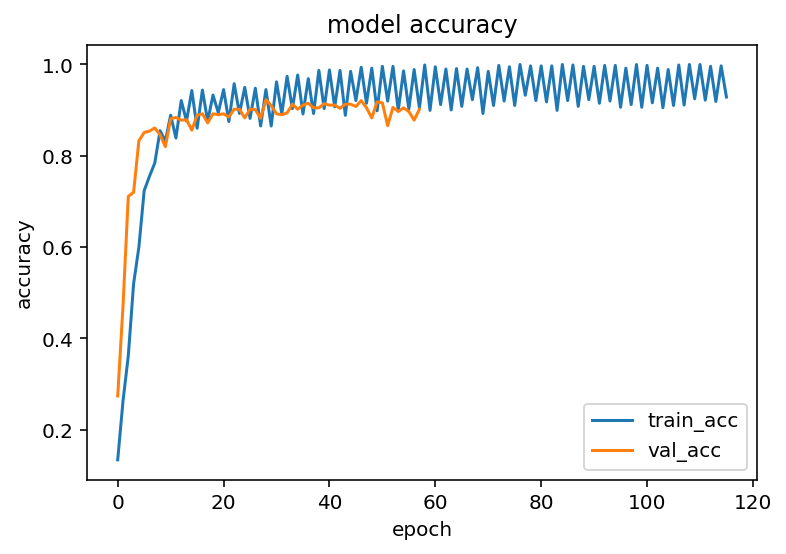

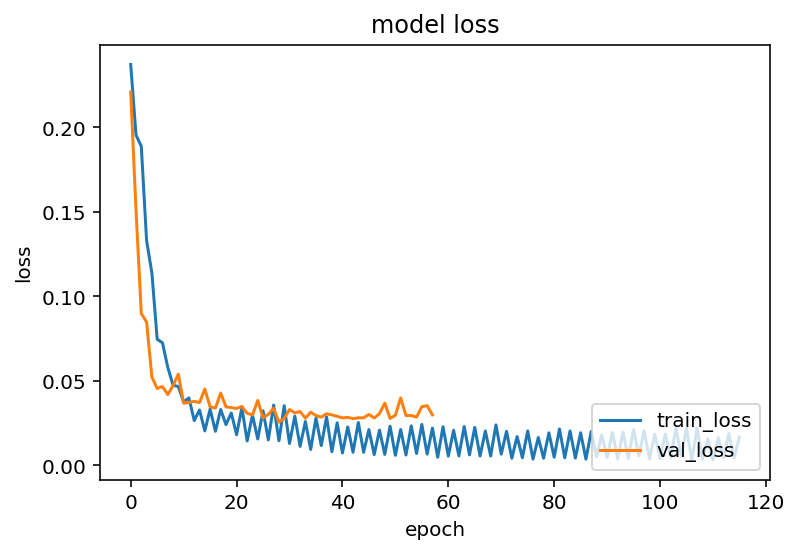

100%|██████████| 20/20 [00:02<00:00,  7.26it/s]
[2017-12-06 05:46:29,576 INFO] Epoch: 0 | TrainAcc: 0.1030 | TrainLoss: 0.2597
[2017-12-06 05:46:30,256 INFO] Epoch: 0 | TrainAcc: 0.1602 | TrainLoss: 0.2087
[2017-12-06 05:46:30,642 INFO] Epoch: 0 | ValAcc: 0.1780 | ValLoss: 0.2263 

[2017-12-06 05:46:31,412 INFO] Epoch: 1 | TrainAcc: 0.2360 | TrainLoss: 0.2213
[2017-12-06 05:46:32,223 INFO] Epoch: 1 | TrainAcc: 0.3193 | TrainLoss: 0.1872
[2017-12-06 05:46:32,661 INFO] Epoch: 1 | ValAcc: 0.2460 | ValLoss: 0.2110 

[2017-12-06 05:46:33,427 INFO] Epoch: 2 | TrainAcc: 0.4100 | TrainLoss: 0.1907
[2017-12-06 05:46:34,156 INFO] Epoch: 2 | TrainAcc: 0.5068 | TrainLoss: 0.1455
[2017-12-06 05:46:34,608 INFO] Epoch: 2 | ValAcc: 0.4570 | ValLoss: 0.1637 

[2017-12-06 05:46:35,458 INFO] Epoch: 3 | TrainAcc: 0.5230 | TrainLoss: 0.1393
[2017-12-06 05:46:36,307 INFO] Epoch: 3 | TrainAcc: 0.6182 | TrainLoss: 0.0983
[2017-12-06 05:46:36,774 INFO] Epoch: 3 | ValAcc: 0.6330 | ValLoss: 0.1099 

[2017-12-06 

[2017-12-06 05:47:29,481 INFO] Epoch: 34 | TrainAcc: 0.8818 | TrainLoss: 0.0305
[2017-12-06 05:47:29,851 INFO] Epoch: 34 | ValAcc: 0.8660 | ValLoss: 0.0393 

[2017-12-06 05:47:30,535 INFO] Epoch: 35 | TrainAcc: 0.9770 | TrainLoss: 0.0096
[2017-12-06 05:47:31,219 INFO] Epoch: 35 | TrainAcc: 0.8916 | TrainLoss: 0.0267
[2017-12-06 05:47:31,602 INFO] Epoch: 35 | ValAcc: 0.8920 | ValLoss: 0.0340 

[2017-12-06 05:47:32,320 INFO] Epoch: 36 | TrainAcc: 0.9850 | TrainLoss: 0.0073
[2017-12-06 05:47:32,985 INFO] Epoch: 36 | TrainAcc: 0.9160 | TrainLoss: 0.0237
[2017-12-06 05:47:33,376 INFO] Epoch: 36 | ValAcc: 0.9010 | ValLoss: 0.0319 

[2017-12-06 05:47:34,099 INFO] Epoch: 37 | TrainAcc: 0.9810 | TrainLoss: 0.0085
[2017-12-06 05:47:34,738 INFO] Epoch: 37 | TrainAcc: 0.9189 | TrainLoss: 0.0223
[2017-12-06 05:47:35,094 INFO] Epoch: 37 | ValAcc: 0.9050 | ValLoss: 0.0284 

[2017-12-06 05:47:35,830 INFO] Epoch: 38 | TrainAcc: 0.9960 | TrainLoss: 0.0050
[2017-12-06 05:47:36,557 INFO] Epoch: 38 | Train

[2017-12-06 05:48:32,923 INFO] Epoch: 69 | TrainAcc: 0.9950 | TrainLoss: 0.0053
[2017-12-06 05:48:33,609 INFO] Epoch: 69 | TrainAcc: 0.9229 | TrainLoss: 0.0210
[2017-12-06 05:48:33,987 INFO] Epoch: 69 | ValAcc: 0.9010 | ValLoss: 0.0308 

[2017-12-06 05:48:34,699 INFO] Epoch: 70 | TrainAcc: 0.9990 | TrainLoss: 0.0039
[2017-12-06 05:48:35,383 INFO] Epoch: 70 | TrainAcc: 0.9092 | TrainLoss: 0.0211
[2017-12-06 05:48:35,759 INFO] Epoch: 70 | ValAcc: 0.8940 | ValLoss: 0.0307 

[2017-12-06 05:48:36,456 INFO] Epoch: 71 | TrainAcc: 0.9970 | TrainLoss: 0.0041
[2017-12-06 05:48:37,233 INFO] Epoch: 71 | TrainAcc: 0.9219 | TrainLoss: 0.0172
[2017-12-06 05:48:37,741 INFO] Epoch: 71 | ValAcc: 0.9100 | ValLoss: 0.0285 

[2017-12-06 05:48:38,466 INFO] Epoch: 72 | TrainAcc: 1.0000 | TrainLoss: 0.0032
[2017-12-06 05:48:39,123 INFO] Epoch: 72 | TrainAcc: 0.9170 | TrainLoss: 0.0216
[2017-12-06 05:48:39,580 INFO] Epoch: 72 | ValAcc: 0.9110 | ValLoss: 0.0293 

[2017-12-06 05:48:40,434 INFO] Epoch: 73 | Train

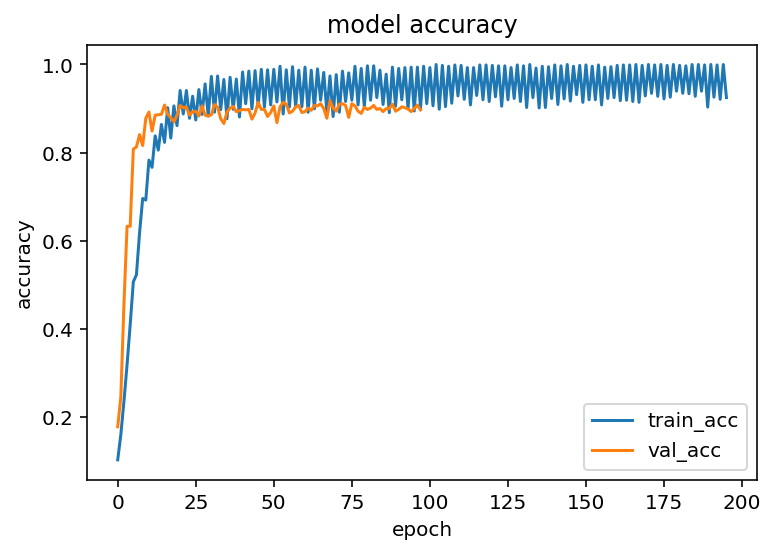

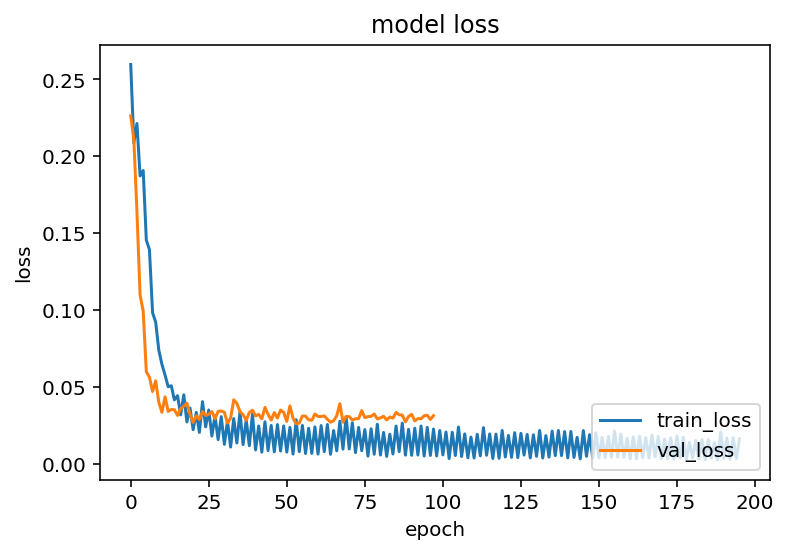

100%|██████████| 20/20 [00:02<00:00,  9.66it/s]
[2017-12-06 05:49:41,390 INFO] Epoch: 0 | TrainAcc: 0.1170 | TrainLoss: 0.2450
[2017-12-06 05:49:42,075 INFO] Epoch: 0 | TrainAcc: 0.2686 | TrainLoss: 0.2030
[2017-12-06 05:49:42,489 INFO] Epoch: 0 | ValAcc: 0.3260 | ValLoss: 0.2163 

[2017-12-06 05:49:43,216 INFO] Epoch: 1 | TrainAcc: 0.3740 | TrainLoss: 0.1959
[2017-12-06 05:49:43,971 INFO] Epoch: 1 | TrainAcc: 0.3916 | TrainLoss: 0.1559
[2017-12-06 05:49:44,427 INFO] Epoch: 1 | ValAcc: 0.5320 | ValLoss: 0.1547 

[2017-12-06 05:49:45,121 INFO] Epoch: 2 | TrainAcc: 0.6350 | TrainLoss: 0.1305
[2017-12-06 05:49:45,790 INFO] Epoch: 2 | TrainAcc: 0.6611 | TrainLoss: 0.0895
[2017-12-06 05:49:46,162 INFO] Epoch: 2 | ValAcc: 0.7300 | ValLoss: 0.0884 

[2017-12-06 05:49:46,826 INFO] Epoch: 3 | TrainAcc: 0.7800 | TrainLoss: 0.0736
[2017-12-06 05:49:47,475 INFO] Epoch: 3 | TrainAcc: 0.7861 | TrainLoss: 0.0565
[2017-12-06 05:49:47,823 INFO] Epoch: 3 | ValAcc: 0.7140 | ValLoss: 0.0849 

[2017-12-06 

[2017-12-06 05:50:39,804 INFO] Epoch: 34 | TrainAcc: 0.9150 | TrainLoss: 0.0241
[2017-12-06 05:50:40,264 INFO] Epoch: 34 | ValAcc: 0.8980 | ValLoss: 0.0311 

[2017-12-06 05:50:40,941 INFO] Epoch: 35 | TrainAcc: 0.9860 | TrainLoss: 0.0071
[2017-12-06 05:50:41,578 INFO] Epoch: 35 | TrainAcc: 0.8945 | TrainLoss: 0.0275
[2017-12-06 05:50:41,935 INFO] Epoch: 35 | ValAcc: 0.9130 | ValLoss: 0.0290 

[2017-12-06 05:50:42,623 INFO] Epoch: 36 | TrainAcc: 0.9870 | TrainLoss: 0.0075
[2017-12-06 05:50:43,255 INFO] Epoch: 36 | TrainAcc: 0.9199 | TrainLoss: 0.0204
[2017-12-06 05:50:43,609 INFO] Epoch: 36 | ValAcc: 0.8960 | ValLoss: 0.0304 

[2017-12-06 05:50:44,294 INFO] Epoch: 37 | TrainAcc: 0.9930 | TrainLoss: 0.0051
[2017-12-06 05:50:44,928 INFO] Epoch: 37 | TrainAcc: 0.8994 | TrainLoss: 0.0222
[2017-12-06 05:50:45,288 INFO] Epoch: 37 | ValAcc: 0.8980 | ValLoss: 0.0330 

[2017-12-06 05:50:45,962 INFO] Epoch: 38 | TrainAcc: 0.9970 | TrainLoss: 0.0056
[2017-12-06 05:50:46,586 INFO] Epoch: 38 | Train

[2017-12-06 05:51:37,747 INFO] Epoch: 69 | TrainAcc: 0.9920 | TrainLoss: 0.0068
[2017-12-06 05:51:38,390 INFO] Epoch: 69 | TrainAcc: 0.9072 | TrainLoss: 0.0210
[2017-12-06 05:51:38,753 INFO] Epoch: 69 | ValAcc: 0.9140 | ValLoss: 0.0284 

[2017-12-06 05:51:39,416 INFO] Epoch: 70 | TrainAcc: 0.9970 | TrainLoss: 0.0039
[2017-12-06 05:51:40,061 INFO] Epoch: 70 | TrainAcc: 0.9424 | TrainLoss: 0.0153
[2017-12-06 05:51:40,410 INFO] Epoch: 70 | ValAcc: 0.9020 | ValLoss: 0.0307 

[2017-12-06 05:51:41,082 INFO] Epoch: 71 | TrainAcc: 0.9960 | TrainLoss: 0.0042
[2017-12-06 05:51:41,697 INFO] Epoch: 71 | TrainAcc: 0.9180 | TrainLoss: 0.0179
[2017-12-06 05:51:42,092 INFO] Epoch: 71 | ValAcc: 0.8880 | ValLoss: 0.0348 

[2017-12-06 05:51:42,753 INFO] Epoch: 72 | TrainAcc: 0.9980 | TrainLoss: 0.0036
[2017-12-06 05:51:43,380 INFO] Epoch: 72 | TrainAcc: 0.9229 | TrainLoss: 0.0170
[2017-12-06 05:51:43,734 INFO] Epoch: 72 | ValAcc: 0.8890 | ValLoss: 0.0342 

[2017-12-06 05:51:44,410 INFO] Epoch: 73 | Train

[2017-12-06 05:52:35,478 INFO] Epoch: 103 | ValAcc: 0.9010 | ValLoss: 0.0323 

[2017-12-06 05:52:36,139 INFO] Epoch: 104 | TrainAcc: 0.9960 | TrainLoss: 0.0036
[2017-12-06 05:52:36,779 INFO] Epoch: 104 | TrainAcc: 0.9209 | TrainLoss: 0.0190
[2017-12-06 05:52:37,138 INFO] Epoch: 104 | ValAcc: 0.9020 | ValLoss: 0.0309 

[2017-12-06 05:52:37,826 INFO] Epoch: 105 | TrainAcc: 0.9970 | TrainLoss: 0.0034
[2017-12-06 05:52:38,444 INFO] Epoch: 105 | TrainAcc: 0.9141 | TrainLoss: 0.0182
[2017-12-06 05:52:38,799 INFO] Epoch: 105 | ValAcc: 0.8890 | ValLoss: 0.0354 

[2017-12-06 05:52:39,465 INFO] Epoch: 106 | TrainAcc: 0.9960 | TrainLoss: 0.0043
[2017-12-06 05:52:40,093 INFO] Epoch: 106 | TrainAcc: 0.9082 | TrainLoss: 0.0191
[2017-12-06 05:52:40,453 INFO] Epoch: 106 | ValAcc: 0.8930 | ValLoss: 0.0308 

[2017-12-06 05:52:41,123 INFO] Epoch: 107 | TrainAcc: 0.9970 | TrainLoss: 0.0042
[2017-12-06 05:52:41,745 INFO] Epoch: 107 | TrainAcc: 0.9160 | TrainLoss: 0.0175
[2017-12-06 05:52:42,125 INFO] Epoch

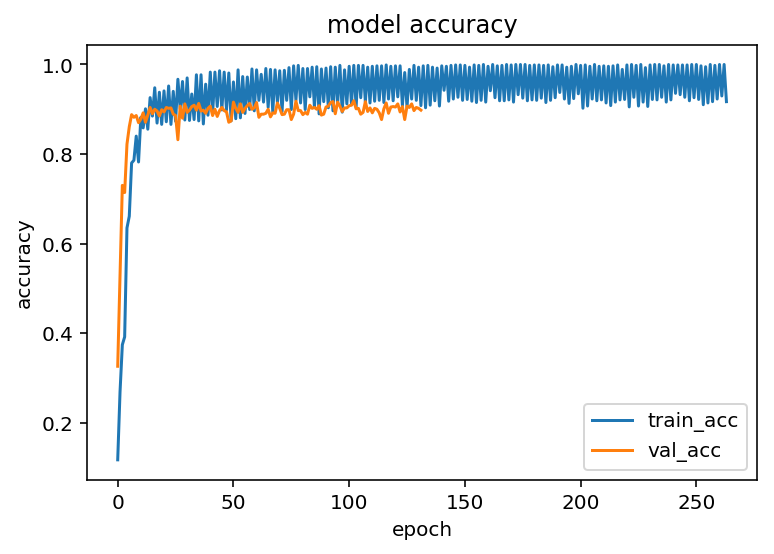

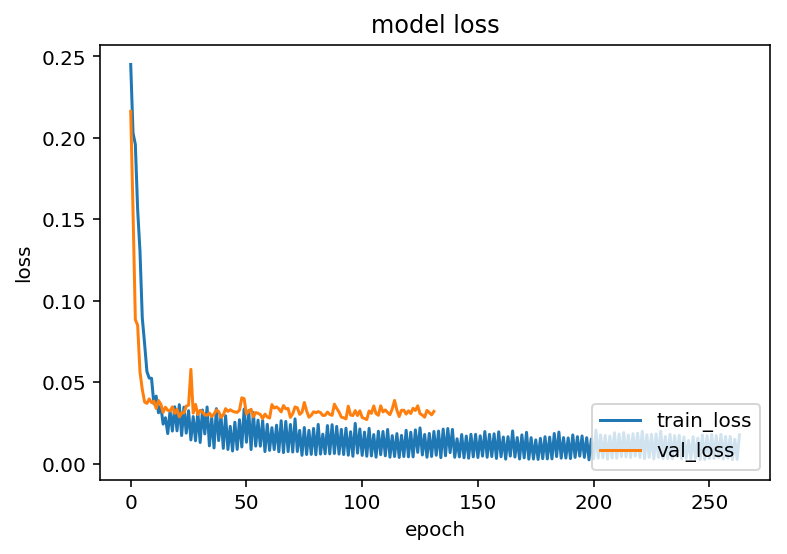

100%|██████████| 20/20 [00:02<00:00,  9.57it/s]
[2017-12-06 05:53:36,700 INFO] Epoch: 0 | TrainAcc: 0.1420 | TrainLoss: 0.2412
[2017-12-06 05:53:37,338 INFO] Epoch: 0 | TrainAcc: 0.2578 | TrainLoss: 0.1935
[2017-12-06 05:53:37,707 INFO] Epoch: 0 | ValAcc: 0.2200 | ValLoss: 0.2161 

[2017-12-06 05:53:38,396 INFO] Epoch: 1 | TrainAcc: 0.3640 | TrainLoss: 0.1832
[2017-12-06 05:53:39,040 INFO] Epoch: 1 | TrainAcc: 0.4531 | TrainLoss: 0.1382
[2017-12-06 05:53:39,402 INFO] Epoch: 1 | ValAcc: 0.5140 | ValLoss: 0.1553 

[2017-12-06 05:53:40,076 INFO] Epoch: 2 | TrainAcc: 0.5900 | TrainLoss: 0.1251
[2017-12-06 05:53:40,722 INFO] Epoch: 2 | TrainAcc: 0.6201 | TrainLoss: 0.0968
[2017-12-06 05:53:41,089 INFO] Epoch: 2 | ValAcc: 0.5820 | ValLoss: 0.1304 

[2017-12-06 05:53:41,753 INFO] Epoch: 3 | TrainAcc: 0.7120 | TrainLoss: 0.0880
[2017-12-06 05:53:42,408 INFO] Epoch: 3 | TrainAcc: 0.7441 | TrainLoss: 0.0679
[2017-12-06 05:53:42,780 INFO] Epoch: 3 | ValAcc: 0.6040 | ValLoss: 0.1398 

[2017-12-06 

[2017-12-06 05:54:34,531 INFO] Epoch: 34 | TrainAcc: 0.9053 | TrainLoss: 0.0223
[2017-12-06 05:54:34,897 INFO] Epoch: 34 | ValAcc: 0.9010 | ValLoss: 0.0309 

[2017-12-06 05:54:35,561 INFO] Epoch: 35 | TrainAcc: 0.9920 | TrainLoss: 0.0053
[2017-12-06 05:54:36,189 INFO] Epoch: 35 | TrainAcc: 0.9043 | TrainLoss: 0.0226
[2017-12-06 05:54:36,551 INFO] Epoch: 35 | ValAcc: 0.9080 | ValLoss: 0.0296 

[2017-12-06 05:54:37,226 INFO] Epoch: 36 | TrainAcc: 0.9870 | TrainLoss: 0.0068
[2017-12-06 05:54:37,880 INFO] Epoch: 36 | TrainAcc: 0.9131 | TrainLoss: 0.0210
[2017-12-06 05:54:38,241 INFO] Epoch: 36 | ValAcc: 0.8730 | ValLoss: 0.0396 

[2017-12-06 05:54:38,938 INFO] Epoch: 37 | TrainAcc: 0.9950 | TrainLoss: 0.0054
[2017-12-06 05:54:39,578 INFO] Epoch: 37 | TrainAcc: 0.9219 | TrainLoss: 0.0201
[2017-12-06 05:54:39,944 INFO] Epoch: 37 | ValAcc: 0.9100 | ValLoss: 0.0279 

[2017-12-06 05:54:40,613 INFO] Epoch: 38 | TrainAcc: 0.9810 | TrainLoss: 0.0069
[2017-12-06 05:54:41,240 INFO] Epoch: 38 | Train

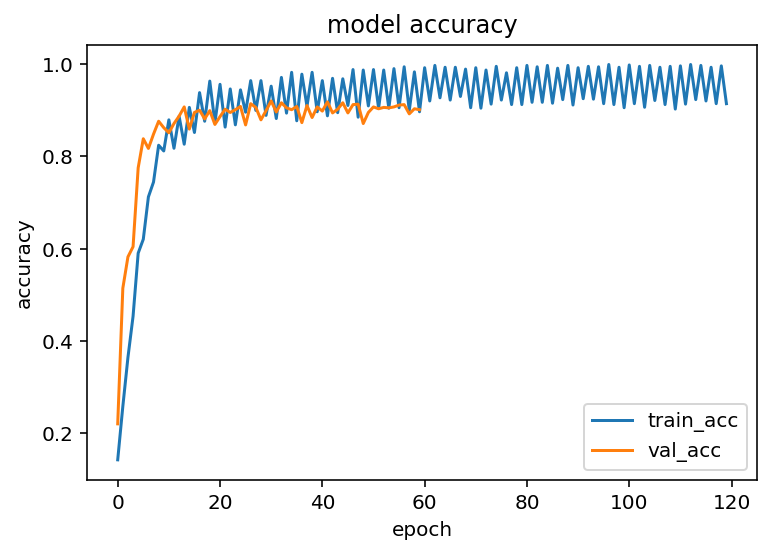

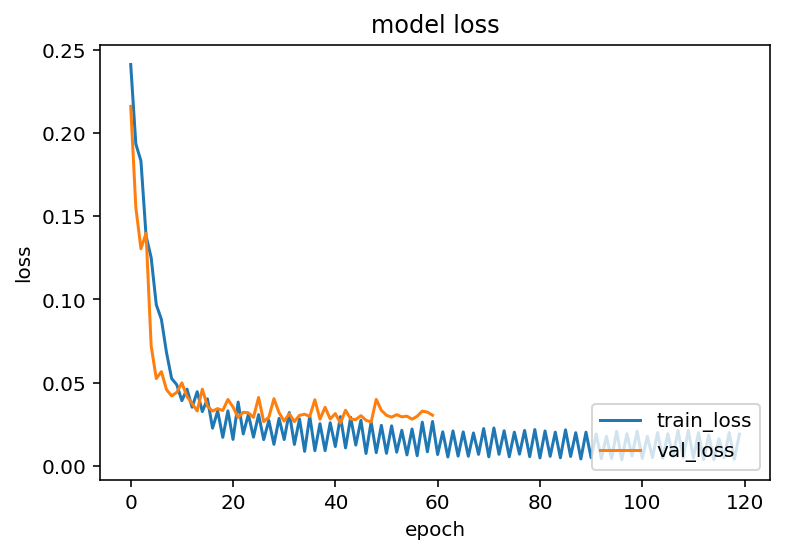

100%|██████████| 20/20 [00:02<00:00,  9.54it/s]
[2017-12-06 05:55:31,595 INFO] Epoch: 0 | TrainAcc: 0.1130 | TrainLoss: 0.2387
[2017-12-06 05:55:32,233 INFO] Epoch: 0 | TrainAcc: 0.2070 | TrainLoss: 0.1980
[2017-12-06 05:55:32,606 INFO] Epoch: 0 | ValAcc: 0.2420 | ValLoss: 0.2185 

[2017-12-06 05:55:33,331 INFO] Epoch: 1 | TrainAcc: 0.3290 | TrainLoss: 0.1971
[2017-12-06 05:55:33,959 INFO] Epoch: 1 | TrainAcc: 0.4238 | TrainLoss: 0.1505
[2017-12-06 05:55:34,320 INFO] Epoch: 1 | ValAcc: 0.3900 | ValLoss: 0.1611 

[2017-12-06 05:55:35,012 INFO] Epoch: 2 | TrainAcc: 0.5560 | TrainLoss: 0.1332
[2017-12-06 05:55:35,663 INFO] Epoch: 2 | TrainAcc: 0.7412 | TrainLoss: 0.0763
[2017-12-06 05:55:36,017 INFO] Epoch: 2 | ValAcc: 0.7430 | ValLoss: 0.0850 

[2017-12-06 05:55:36,708 INFO] Epoch: 3 | TrainAcc: 0.7520 | TrainLoss: 0.0763
[2017-12-06 05:55:37,350 INFO] Epoch: 3 | TrainAcc: 0.7314 | TrainLoss: 0.0655
[2017-12-06 05:55:37,717 INFO] Epoch: 3 | ValAcc: 0.7900 | ValLoss: 0.0600 

[2017-12-06 

[2017-12-06 05:56:30,053 INFO] Epoch: 34 | TrainAcc: 0.9238 | TrainLoss: 0.0190
[2017-12-06 05:56:30,424 INFO] Epoch: 34 | ValAcc: 0.9090 | ValLoss: 0.0311 

[2017-12-06 05:56:31,098 INFO] Epoch: 35 | TrainAcc: 0.9980 | TrainLoss: 0.0043
[2017-12-06 05:56:31,739 INFO] Epoch: 35 | TrainAcc: 0.9268 | TrainLoss: 0.0169
[2017-12-06 05:56:32,116 INFO] Epoch: 35 | ValAcc: 0.9060 | ValLoss: 0.0308 

[2017-12-06 05:56:32,792 INFO] Epoch: 36 | TrainAcc: 0.9950 | TrainLoss: 0.0046
[2017-12-06 05:56:33,444 INFO] Epoch: 36 | TrainAcc: 0.9209 | TrainLoss: 0.0198
[2017-12-06 05:56:33,814 INFO] Epoch: 36 | ValAcc: 0.9040 | ValLoss: 0.0318 

[2017-12-06 05:56:34,487 INFO] Epoch: 37 | TrainAcc: 0.9950 | TrainLoss: 0.0047
[2017-12-06 05:56:35,145 INFO] Epoch: 37 | TrainAcc: 0.9072 | TrainLoss: 0.0224
[2017-12-06 05:56:35,512 INFO] Epoch: 37 | ValAcc: 0.9010 | ValLoss: 0.0318 

[2017-12-06 05:56:36,215 INFO] Epoch: 38 | TrainAcc: 0.9950 | TrainLoss: 0.0051
[2017-12-06 05:56:36,857 INFO] Epoch: 38 | Train

[2017-12-06 05:57:28,996 INFO] Epoch: 69 | TrainAcc: 0.9980 | TrainLoss: 0.0033
[2017-12-06 05:57:29,663 INFO] Epoch: 69 | TrainAcc: 0.9346 | TrainLoss: 0.0172
[2017-12-06 05:57:30,027 INFO] Epoch: 69 | ValAcc: 0.9100 | ValLoss: 0.0311 

[2017-12-06 05:57:30,707 INFO] Epoch: 70 | TrainAcc: 1.0000 | TrainLoss: 0.0030
[2017-12-06 05:57:31,351 INFO] Epoch: 70 | TrainAcc: 0.9248 | TrainLoss: 0.0168
[2017-12-06 05:57:31,709 INFO] Epoch: 70 | ValAcc: 0.9060 | ValLoss: 0.0310 

[2017-12-06 05:57:32,416 INFO] Epoch: 71 | TrainAcc: 0.9980 | TrainLoss: 0.0034
[2017-12-06 05:57:33,068 INFO] Epoch: 71 | TrainAcc: 0.9209 | TrainLoss: 0.0180
[2017-12-06 05:57:33,426 INFO] Epoch: 71 | ValAcc: 0.9050 | ValLoss: 0.0313 

[2017-12-06 05:57:34,109 INFO] Epoch: 72 | TrainAcc: 0.9960 | TrainLoss: 0.0033
[2017-12-06 05:57:34,758 INFO] Epoch: 72 | TrainAcc: 0.9131 | TrainLoss: 0.0177
[2017-12-06 05:57:35,117 INFO] Epoch: 72 | ValAcc: 0.9020 | ValLoss: 0.0314 

[2017-12-06 05:57:35,812 INFO] Epoch: 73 | Train

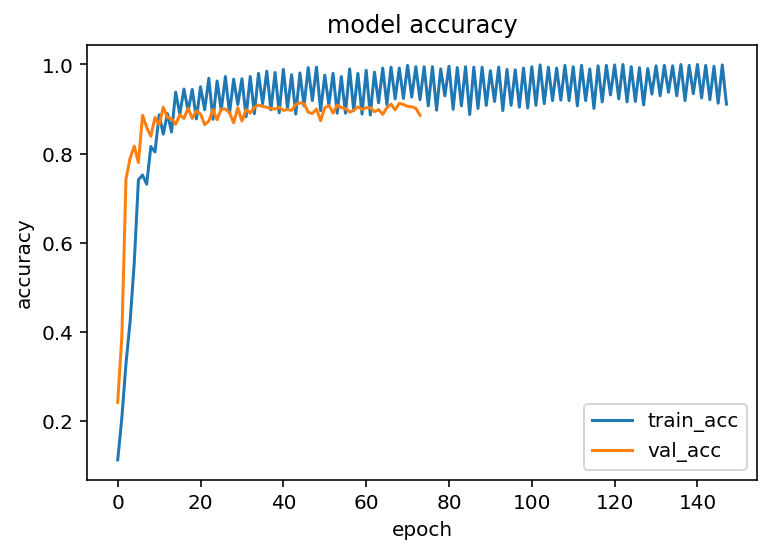

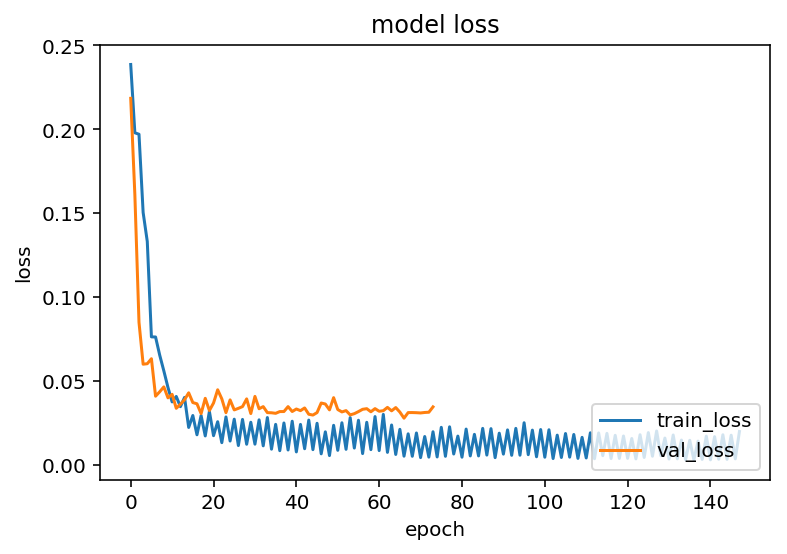

100%|██████████| 20/20 [00:02<00:00,  9.31it/s]
[2017-12-06 05:57:51,381 INFO] Epoch: 0 | TrainAcc: 0.1290 | TrainLoss: 0.2542
[2017-12-06 05:57:52,032 INFO] Epoch: 0 | TrainAcc: 0.1123 | TrainLoss: 0.2120
[2017-12-06 05:57:52,400 INFO] Epoch: 0 | ValAcc: 0.1720 | ValLoss: 0.2262 

[2017-12-06 05:57:53,109 INFO] Epoch: 1 | TrainAcc: 0.2100 | TrainLoss: 0.2233
[2017-12-06 05:57:53,767 INFO] Epoch: 1 | TrainAcc: 0.3281 | TrainLoss: 0.1887
[2017-12-06 05:57:54,129 INFO] Epoch: 1 | ValAcc: 0.4510 | ValLoss: 0.2027 

[2017-12-06 05:57:54,818 INFO] Epoch: 2 | TrainAcc: 0.4930 | TrainLoss: 0.1776
[2017-12-06 05:57:55,481 INFO] Epoch: 2 | TrainAcc: 0.5518 | TrainLoss: 0.1239
[2017-12-06 05:57:55,846 INFO] Epoch: 2 | ValAcc: 0.4210 | ValLoss: 0.1602 

[2017-12-06 05:57:56,550 INFO] Epoch: 3 | TrainAcc: 0.6130 | TrainLoss: 0.1132
[2017-12-06 05:57:57,192 INFO] Epoch: 3 | TrainAcc: 0.6309 | TrainLoss: 0.0929
[2017-12-06 05:57:57,549 INFO] Epoch: 3 | ValAcc: 0.7030 | ValLoss: 0.0925 

[2017-12-06 

[2017-12-06 05:58:50,524 INFO] Epoch: 34 | TrainAcc: 0.8828 | TrainLoss: 0.0286
[2017-12-06 05:58:50,888 INFO] Epoch: 34 | ValAcc: 0.9120 | ValLoss: 0.0276 

[2017-12-06 05:58:51,567 INFO] Epoch: 35 | TrainAcc: 0.9870 | TrainLoss: 0.0078
[2017-12-06 05:58:52,228 INFO] Epoch: 35 | TrainAcc: 0.9141 | TrainLoss: 0.0232
[2017-12-06 05:58:52,575 INFO] Epoch: 35 | ValAcc: 0.9030 | ValLoss: 0.0312 

[2017-12-06 05:58:53,295 INFO] Epoch: 36 | TrainAcc: 0.9900 | TrainLoss: 0.0063
[2017-12-06 05:58:53,975 INFO] Epoch: 36 | TrainAcc: 0.9072 | TrainLoss: 0.0257
[2017-12-06 05:58:54,335 INFO] Epoch: 36 | ValAcc: 0.9230 | ValLoss: 0.0272 

[2017-12-06 05:58:55,012 INFO] Epoch: 37 | TrainAcc: 0.9910 | TrainLoss: 0.0064
[2017-12-06 05:58:55,665 INFO] Epoch: 37 | TrainAcc: 0.9141 | TrainLoss: 0.0244
[2017-12-06 05:58:56,035 INFO] Epoch: 37 | ValAcc: 0.9030 | ValLoss: 0.0308 

[2017-12-06 05:58:56,732 INFO] Epoch: 38 | TrainAcc: 0.9880 | TrainLoss: 0.0074
[2017-12-06 05:58:57,382 INFO] Epoch: 38 | Train

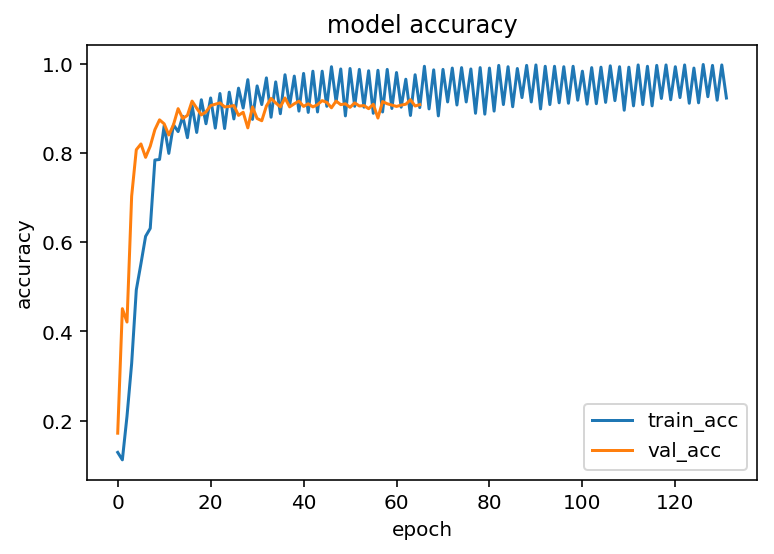

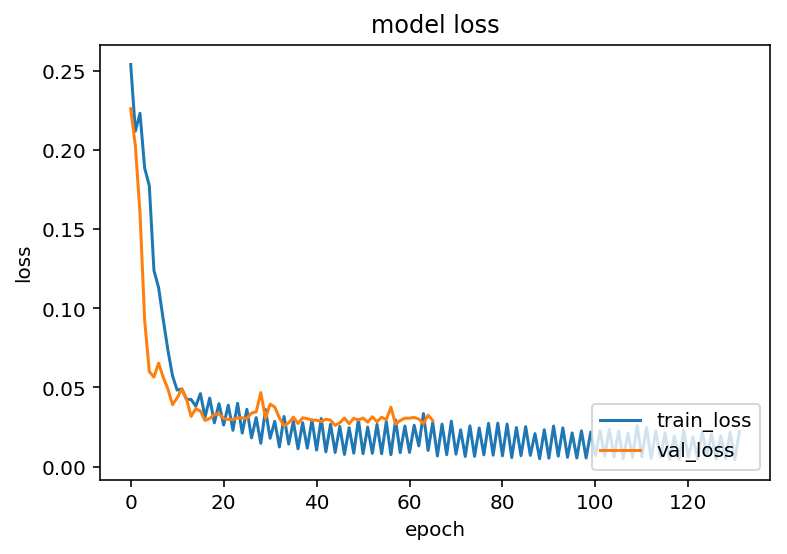

100%|██████████| 20/20 [00:02<00:00,  9.33it/s]
[2017-12-06 05:59:58,936 INFO] Epoch: 0 | TrainAcc: 0.1280 | TrainLoss: 0.2360
[2017-12-06 05:59:59,601 INFO] Epoch: 0 | TrainAcc: 0.2520 | TrainLoss: 0.1978
[2017-12-06 05:59:59,967 INFO] Epoch: 0 | ValAcc: 0.3040 | ValLoss: 0.2124 

[2017-12-06 06:00:00,677 INFO] Epoch: 1 | TrainAcc: 0.3650 | TrainLoss: 0.1854
[2017-12-06 06:00:01,336 INFO] Epoch: 1 | TrainAcc: 0.4082 | TrainLoss: 0.1500
[2017-12-06 06:00:01,702 INFO] Epoch: 1 | ValAcc: 0.5120 | ValLoss: 0.1463 

[2017-12-06 06:00:02,389 INFO] Epoch: 2 | TrainAcc: 0.6190 | TrainLoss: 0.1206
[2017-12-06 06:00:03,052 INFO] Epoch: 2 | TrainAcc: 0.7002 | TrainLoss: 0.0774
[2017-12-06 06:00:03,418 INFO] Epoch: 2 | ValAcc: 0.5910 | ValLoss: 0.1088 

[2017-12-06 06:00:04,134 INFO] Epoch: 3 | TrainAcc: 0.7870 | TrainLoss: 0.0676
[2017-12-06 06:00:04,797 INFO] Epoch: 3 | TrainAcc: 0.8066 | TrainLoss: 0.0507
[2017-12-06 06:00:05,159 INFO] Epoch: 3 | ValAcc: 0.7670 | ValLoss: 0.0722 

[2017-12-06 

[2017-12-06 06:00:58,189 INFO] Epoch: 34 | TrainAcc: 0.8916 | TrainLoss: 0.0254
[2017-12-06 06:00:58,542 INFO] Epoch: 34 | ValAcc: 0.9160 | ValLoss: 0.0286 

[2017-12-06 06:00:59,249 INFO] Epoch: 35 | TrainAcc: 0.9920 | TrainLoss: 0.0061
[2017-12-06 06:00:59,904 INFO] Epoch: 35 | TrainAcc: 0.9111 | TrainLoss: 0.0232
[2017-12-06 06:01:00,262 INFO] Epoch: 35 | ValAcc: 0.8970 | ValLoss: 0.0319 

[2017-12-06 06:01:00,921 INFO] Epoch: 36 | TrainAcc: 0.9970 | TrainLoss: 0.0054
[2017-12-06 06:01:01,588 INFO] Epoch: 36 | TrainAcc: 0.9082 | TrainLoss: 0.0225
[2017-12-06 06:01:01,941 INFO] Epoch: 36 | ValAcc: 0.8990 | ValLoss: 0.0328 

[2017-12-06 06:01:02,625 INFO] Epoch: 37 | TrainAcc: 0.9910 | TrainLoss: 0.0065
[2017-12-06 06:01:03,238 INFO] Epoch: 37 | TrainAcc: 0.9150 | TrainLoss: 0.0217
[2017-12-06 06:01:03,595 INFO] Epoch: 37 | ValAcc: 0.9030 | ValLoss: 0.0326 

[2017-12-06 06:01:04,261 INFO] Epoch: 38 | TrainAcc: 0.9910 | TrainLoss: 0.0063
[2017-12-06 06:01:04,924 INFO] Epoch: 38 | Train

[2017-12-06 06:49:19,630 INFO] Epoch: 69 | TrainAcc: 1.0000 | TrainLoss: 0.0034
[2017-12-06 06:49:20,355 INFO] Epoch: 69 | TrainAcc: 0.9141 | TrainLoss: 0.0191
[2017-12-06 06:49:20,717 INFO] Epoch: 69 | ValAcc: 0.9040 | ValLoss: 0.0305 

[2017-12-06 06:49:21,422 INFO] Epoch: 70 | TrainAcc: 0.9990 | TrainLoss: 0.0043
[2017-12-06 06:49:22,098 INFO] Epoch: 70 | TrainAcc: 0.9102 | TrainLoss: 0.0214
[2017-12-06 06:49:22,471 INFO] Epoch: 70 | ValAcc: 0.8910 | ValLoss: 0.0368 

[2017-12-06 06:49:23,126 INFO] Epoch: 71 | TrainAcc: 0.9940 | TrainLoss: 0.0054
[2017-12-06 06:49:23,786 INFO] Epoch: 71 | TrainAcc: 0.9072 | TrainLoss: 0.0206
[2017-12-06 06:49:24,161 INFO] Epoch: 71 | ValAcc: 0.9040 | ValLoss: 0.0279 

[2017-12-06 06:49:24,818 INFO] Epoch: 72 | TrainAcc: 0.9980 | TrainLoss: 0.0040
[2017-12-06 06:49:25,436 INFO] Epoch: 72 | TrainAcc: 0.9141 | TrainLoss: 0.0185
[2017-12-06 06:49:25,789 INFO] Epoch: 72 | ValAcc: 0.9140 | ValLoss: 0.0307 

[2017-12-06 06:49:26,459 INFO] Epoch: 73 | Train

[2017-12-06 07:54:27,764 INFO] Epoch: 103 | ValAcc: 0.8990 | ValLoss: 0.0343 

[2017-12-06 07:54:28,443 INFO] Epoch: 104 | TrainAcc: 0.9970 | TrainLoss: 0.0035
[2017-12-06 07:54:29,082 INFO] Epoch: 104 | TrainAcc: 0.9258 | TrainLoss: 0.0164
[2017-12-06 07:54:29,450 INFO] Epoch: 104 | ValAcc: 0.9040 | ValLoss: 0.0317 

[2017-12-06 07:54:30,122 INFO] Epoch: 105 | TrainAcc: 0.9980 | TrainLoss: 0.0037
[2017-12-06 07:54:30,750 INFO] Epoch: 105 | TrainAcc: 0.9170 | TrainLoss: 0.0176
[2017-12-06 07:54:31,113 INFO] Epoch: 105 | ValAcc: 0.9120 | ValLoss: 0.0289 

[2017-12-06 07:54:31,782 INFO] Epoch: 106 | TrainAcc: 0.9990 | TrainLoss: 0.0029
[2017-12-06 07:54:32,421 INFO] Epoch: 106 | TrainAcc: 0.9238 | TrainLoss: 0.0168
[2017-12-06 07:54:32,787 INFO] Epoch: 106 | ValAcc: 0.9200 | ValLoss: 0.0278 

[2017-12-06 07:54:33,448 INFO] Epoch: 107 | TrainAcc: 0.9980 | TrainLoss: 0.0037
[2017-12-06 07:54:34,089 INFO] Epoch: 107 | TrainAcc: 0.9160 | TrainLoss: 0.0167
[2017-12-06 07:54:34,445 INFO] Epoch

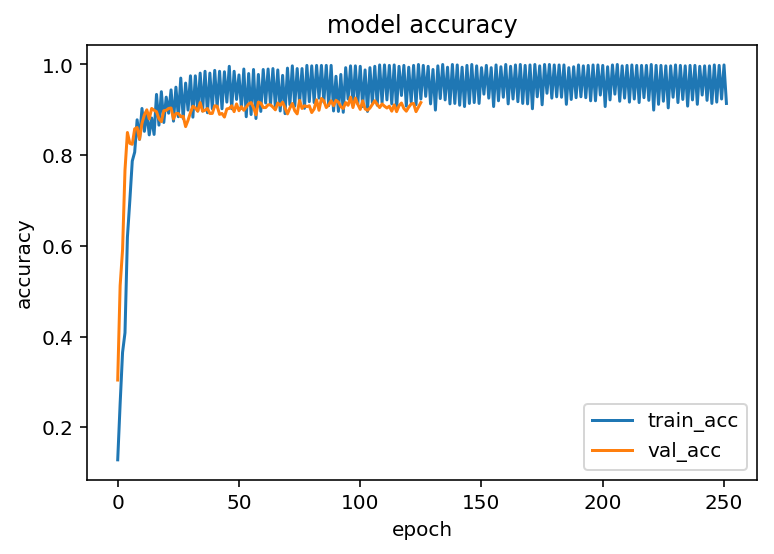

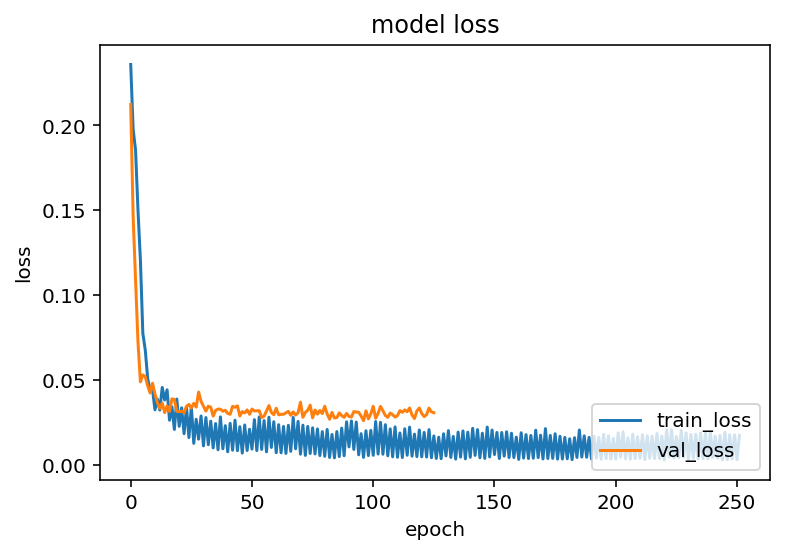

100%|██████████| 20/20 [00:02<00:00,  9.45it/s]
[2017-12-06 08:49:54,714 INFO] Epoch: 0 | TrainAcc: 0.1350 | TrainLoss: 0.2334
[2017-12-06 08:49:56,360 INFO] Epoch: 0 | TrainAcc: 0.2676 | TrainLoss: 0.1980
[2017-12-06 08:49:59,299 INFO] Epoch: 0 | ValAcc: 0.3490 | ValLoss: 0.2177 

[2017-12-06 08:50:04,991 INFO] Epoch: 1 | TrainAcc: 0.3530 | TrainLoss: 0.1894
[2017-12-06 08:50:06,336 INFO] Epoch: 1 | TrainAcc: 0.4834 | TrainLoss: 0.1427
[2017-12-06 08:50:06,805 INFO] Epoch: 1 | ValAcc: 0.3110 | ValLoss: 0.1957 

[2017-12-06 08:50:07,526 INFO] Epoch: 2 | TrainAcc: 0.5440 | TrainLoss: 0.1322
[2017-12-06 08:50:08,169 INFO] Epoch: 2 | TrainAcc: 0.5977 | TrainLoss: 0.1020
[2017-12-06 08:50:08,519 INFO] Epoch: 2 | ValAcc: 0.5870 | ValLoss: 0.1132 

[2017-12-06 08:50:09,204 INFO] Epoch: 3 | TrainAcc: 0.7100 | TrainLoss: 0.0874
[2017-12-06 08:50:09,843 INFO] Epoch: 3 | TrainAcc: 0.7070 | TrainLoss: 0.0684
[2017-12-06 08:50:10,200 INFO] Epoch: 3 | ValAcc: 0.7790 | ValLoss: 0.0682 

[2017-12-06 

[2017-12-06 09:52:44,487 INFO] Epoch: 34 | TrainAcc: 0.8984 | TrainLoss: 0.0254
[2017-12-06 09:52:44,836 INFO] Epoch: 34 | ValAcc: 0.9180 | ValLoss: 0.0285 

[2017-12-06 09:52:45,551 INFO] Epoch: 35 | TrainAcc: 0.9930 | TrainLoss: 0.0059
[2017-12-06 09:52:46,190 INFO] Epoch: 35 | TrainAcc: 0.9150 | TrainLoss: 0.0207
[2017-12-06 09:52:46,546 INFO] Epoch: 35 | ValAcc: 0.9140 | ValLoss: 0.0303 

[2017-12-06 09:52:47,203 INFO] Epoch: 36 | TrainAcc: 0.9900 | TrainLoss: 0.0060
[2017-12-06 09:52:47,907 INFO] Epoch: 36 | TrainAcc: 0.9043 | TrainLoss: 0.0249
[2017-12-06 09:52:48,288 INFO] Epoch: 36 | ValAcc: 0.9170 | ValLoss: 0.0324 

[2017-12-06 09:52:48,990 INFO] Epoch: 37 | TrainAcc: 0.9860 | TrainLoss: 0.0068
[2017-12-06 09:52:49,641 INFO] Epoch: 37 | TrainAcc: 0.8916 | TrainLoss: 0.0264
[2017-12-06 09:52:50,014 INFO] Epoch: 37 | ValAcc: 0.9150 | ValLoss: 0.0305 

[2017-12-06 09:52:50,756 INFO] Epoch: 38 | TrainAcc: 0.9920 | TrainLoss: 0.0055
[2017-12-06 09:52:51,873 INFO] Epoch: 38 | Train

[2017-12-06 10:36:26,383 INFO] Epoch: 69 | TrainAcc: 0.9950 | TrainLoss: 0.0046
[2017-12-06 10:36:27,042 INFO] Epoch: 69 | TrainAcc: 0.9209 | TrainLoss: 0.0174
[2017-12-06 10:36:27,414 INFO] Epoch: 69 | ValAcc: 0.9250 | ValLoss: 0.0276 

[2017-12-06 10:36:28,124 INFO] Epoch: 70 | TrainAcc: 0.9980 | TrainLoss: 0.0029
[2017-12-06 11:54:03,207 INFO] Epoch: 70 | TrainAcc: 0.9180 | TrainLoss: 0.0191
[2017-12-06 11:54:03,620 INFO] Epoch: 70 | ValAcc: 0.9220 | ValLoss: 0.0285 

[2017-12-06 11:54:04,372 INFO] Epoch: 71 | TrainAcc: 1.0000 | TrainLoss: 0.0035
[2017-12-06 11:54:05,174 INFO] Epoch: 71 | TrainAcc: 0.9238 | TrainLoss: 0.0169
[2017-12-06 11:54:05,610 INFO] Epoch: 71 | ValAcc: 0.9030 | ValLoss: 0.0337 

[2017-12-06 11:54:06,377 INFO] Epoch: 72 | TrainAcc: 0.9990 | TrainLoss: 0.0034
[2017-12-06 11:54:07,096 INFO] Epoch: 72 | TrainAcc: 0.9160 | TrainLoss: 0.0175
[2017-12-06 11:54:07,518 INFO] Epoch: 72 | ValAcc: 0.9270 | ValLoss: 0.0261 

[2017-12-06 11:54:08,277 INFO] Epoch: 73 | Train

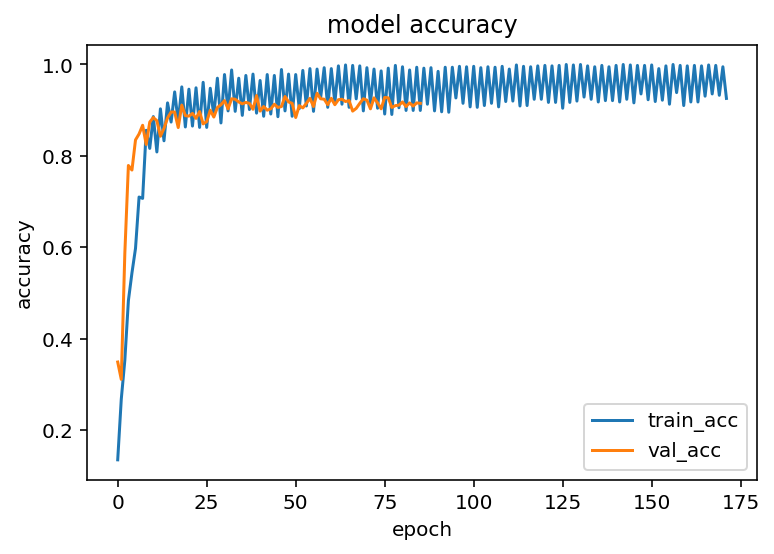

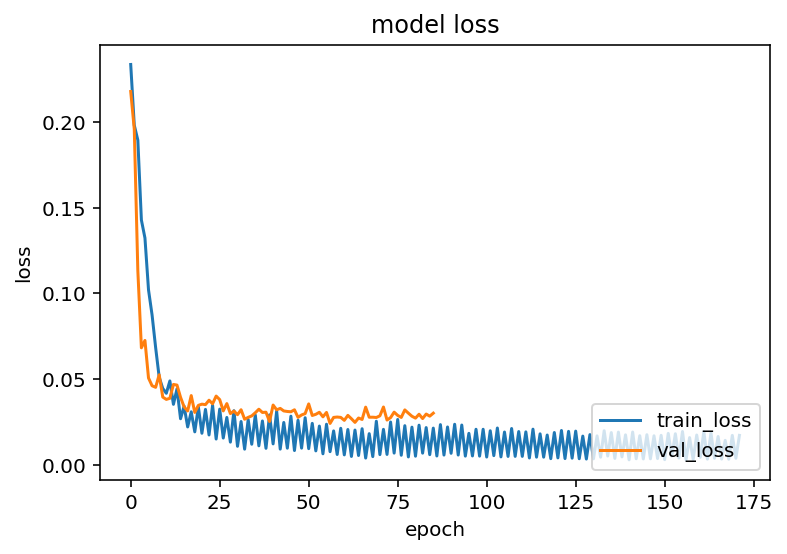

100%|██████████| 20/20 [00:02<00:00,  9.09it/s]
[2017-12-06 11:54:54,075 INFO] Epoch: 0 | TrainAcc: 0.1240 | TrainLoss: 0.2388
[2017-12-06 11:54:54,718 INFO] Epoch: 0 | TrainAcc: 0.2148 | TrainLoss: 0.2068
[2017-12-06 11:54:55,074 INFO] Epoch: 0 | ValAcc: 0.2740 | ValLoss: 0.2198 

[2017-12-06 11:54:55,758 INFO] Epoch: 1 | TrainAcc: 0.2860 | TrainLoss: 0.2029
[2017-12-06 11:54:56,382 INFO] Epoch: 1 | TrainAcc: 0.4043 | TrainLoss: 0.1581
[2017-12-06 11:54:56,753 INFO] Epoch: 1 | ValAcc: 0.3980 | ValLoss: 0.1750 

[2017-12-06 11:54:57,429 INFO] Epoch: 2 | TrainAcc: 0.5890 | TrainLoss: 0.1406
[2017-12-06 11:54:58,079 INFO] Epoch: 2 | TrainAcc: 0.6367 | TrainLoss: 0.0966
[2017-12-06 11:54:58,448 INFO] Epoch: 2 | ValAcc: 0.6080 | ValLoss: 0.1154 

[2017-12-06 11:54:59,126 INFO] Epoch: 3 | TrainAcc: 0.7250 | TrainLoss: 0.0889
[2017-12-06 11:54:59,766 INFO] Epoch: 3 | TrainAcc: 0.7529 | TrainLoss: 0.0636
[2017-12-06 11:55:00,129 INFO] Epoch: 3 | ValAcc: 0.7850 | ValLoss: 0.0692 

[2017-12-06 

[2017-12-06 12:04:10,802 INFO] Epoch: 34 | TrainAcc: 0.9248 | TrainLoss: 0.0205
[2017-12-06 12:04:11,162 INFO] Epoch: 34 | ValAcc: 0.8780 | ValLoss: 0.0362 

[2017-12-06 12:04:11,841 INFO] Epoch: 35 | TrainAcc: 0.9980 | TrainLoss: 0.0049
[2017-12-06 12:04:12,487 INFO] Epoch: 35 | TrainAcc: 0.8975 | TrainLoss: 0.0239
[2017-12-06 12:04:12,843 INFO] Epoch: 35 | ValAcc: 0.8840 | ValLoss: 0.0380 

[2017-12-06 12:04:13,544 INFO] Epoch: 36 | TrainAcc: 0.9860 | TrainLoss: 0.0072
[2017-12-06 12:04:14,163 INFO] Epoch: 36 | TrainAcc: 0.8945 | TrainLoss: 0.0251
[2017-12-06 12:04:14,525 INFO] Epoch: 36 | ValAcc: 0.8930 | ValLoss: 0.0341 

[2017-12-06 12:04:15,183 INFO] Epoch: 37 | TrainAcc: 0.9930 | TrainLoss: 0.0060
[2017-12-06 12:04:15,823 INFO] Epoch: 37 | TrainAcc: 0.9111 | TrainLoss: 0.0224
[2017-12-06 12:04:16,202 INFO] Epoch: 37 | ValAcc: 0.8810 | ValLoss: 0.0384 

[2017-12-06 12:04:16,884 INFO] Epoch: 38 | TrainAcc: 0.9900 | TrainLoss: 0.0069
[2017-12-06 12:04:17,520 INFO] Epoch: 38 | Train

[2017-12-06 13:46:32,040 INFO] Epoch: 69 | TrainAcc: 0.9980 | TrainLoss: 0.0036
[2017-12-06 13:46:32,694 INFO] Epoch: 69 | TrainAcc: 0.9141 | TrainLoss: 0.0206
[2017-12-06 13:46:33,058 INFO] Epoch: 69 | ValAcc: 0.8660 | ValLoss: 0.0417 

[2017-12-06 13:46:33,723 INFO] Epoch: 70 | TrainAcc: 0.9950 | TrainLoss: 0.0044
[2017-12-06 13:46:34,378 INFO] Epoch: 70 | TrainAcc: 0.8994 | TrainLoss: 0.0227
[2017-12-06 13:46:34,732 INFO] Epoch: 70 | ValAcc: 0.8900 | ValLoss: 0.0323 

[2017-12-06 13:46:35,429 INFO] Epoch: 71 | TrainAcc: 0.9970 | TrainLoss: 0.0041
[2017-12-06 13:46:36,087 INFO] Epoch: 71 | TrainAcc: 0.9258 | TrainLoss: 0.0170
[2017-12-06 13:46:36,445 INFO] Epoch: 71 | ValAcc: 0.8910 | ValLoss: 0.0332 

[2017-12-06 13:46:37,112 INFO] Epoch: 72 | TrainAcc: 0.9980 | TrainLoss: 0.0033
[2017-12-06 13:46:37,727 INFO] Epoch: 72 | TrainAcc: 0.9326 | TrainLoss: 0.0168
[2017-12-06 13:46:38,074 INFO] Epoch: 72 | ValAcc: 0.9000 | ValLoss: 0.0326 

[2017-12-06 13:46:43,069 INFO] Epoch: 73 | Train

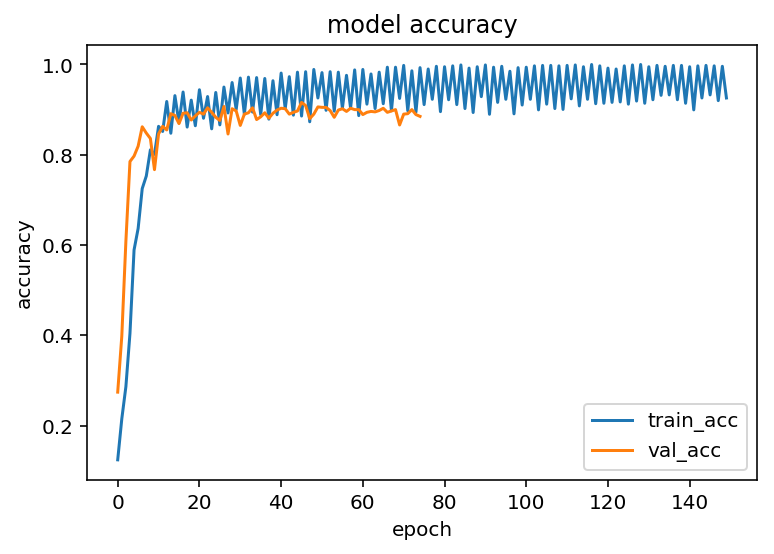

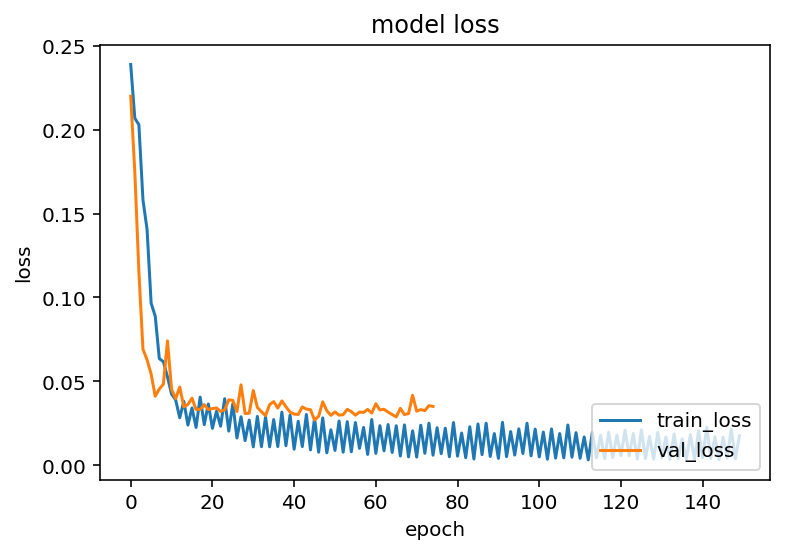

100%|██████████| 20/20 [00:02<00:00,  9.58it/s]
[2017-12-06 13:47:06,701 INFO] Epoch: 0 | TrainAcc: 0.1100 | TrainLoss: 0.2447
[2017-12-06 13:47:07,354 INFO] Epoch: 0 | TrainAcc: 0.2070 | TrainLoss: 0.2068
[2017-12-06 13:47:07,719 INFO] Epoch: 0 | ValAcc: 0.1880 | ValLoss: 0.2252 

[2017-12-06 13:47:08,400 INFO] Epoch: 1 | TrainAcc: 0.2950 | TrainLoss: 0.2088
[2017-12-06 13:47:09,049 INFO] Epoch: 1 | TrainAcc: 0.3828 | TrainLoss: 0.1669
[2017-12-06 13:47:09,406 INFO] Epoch: 1 | ValAcc: 0.4100 | ValLoss: 0.1872 

[2017-12-06 13:47:10,080 INFO] Epoch: 2 | TrainAcc: 0.4460 | TrainLoss: 0.1613
[2017-12-06 13:47:10,704 INFO] Epoch: 2 | TrainAcc: 0.5029 | TrainLoss: 0.1232
[2017-12-06 13:47:11,061 INFO] Epoch: 2 | ValAcc: 0.4030 | ValLoss: 0.1830 

[2017-12-06 13:47:11,741 INFO] Epoch: 3 | TrainAcc: 0.6430 | TrainLoss: 0.1060
[2017-12-06 13:47:12,377 INFO] Epoch: 3 | TrainAcc: 0.6846 | TrainLoss: 0.0762
[2017-12-06 13:47:12,737 INFO] Epoch: 3 | ValAcc: 0.7040 | ValLoss: 0.0912 

[2017-12-06 

[2017-12-06 13:59:27,998 INFO] Epoch: 34 | TrainAcc: 0.9111 | TrainLoss: 0.0199
[2017-12-06 13:59:28,485 INFO] Epoch: 34 | ValAcc: 0.8780 | ValLoss: 0.0387 

[2017-12-06 13:59:29,388 INFO] Epoch: 35 | TrainAcc: 0.9800 | TrainLoss: 0.0079
[2017-12-06 13:59:30,190 INFO] Epoch: 35 | TrainAcc: 0.9043 | TrainLoss: 0.0231
[2017-12-06 13:59:30,681 INFO] Epoch: 35 | ValAcc: 0.9020 | ValLoss: 0.0317 

[2017-12-06 13:59:31,544 INFO] Epoch: 36 | TrainAcc: 0.9880 | TrainLoss: 0.0069
[2017-12-06 13:59:32,326 INFO] Epoch: 36 | TrainAcc: 0.8975 | TrainLoss: 0.0302
[2017-12-06 13:59:32,774 INFO] Epoch: 36 | ValAcc: 0.8820 | ValLoss: 0.0373 

[2017-12-06 13:59:33,692 INFO] Epoch: 37 | TrainAcc: 0.9750 | TrainLoss: 0.0099
[2017-12-06 13:59:34,476 INFO] Epoch: 37 | TrainAcc: 0.9062 | TrainLoss: 0.0218
[2017-12-06 13:59:34,954 INFO] Epoch: 37 | ValAcc: 0.8930 | ValLoss: 0.0349 

[2017-12-06 13:59:35,855 INFO] Epoch: 38 | TrainAcc: 0.9910 | TrainLoss: 0.0062
[2017-12-06 13:59:36,625 INFO] Epoch: 38 | Train

[2017-12-06 14:00:30,206 INFO] Epoch: 69 | TrainAcc: 0.9970 | TrainLoss: 0.0038
[2017-12-06 14:00:30,879 INFO] Epoch: 69 | TrainAcc: 0.9258 | TrainLoss: 0.0150
[2017-12-06 14:00:31,317 INFO] Epoch: 69 | ValAcc: 0.9050 | ValLoss: 0.0319 

[2017-12-06 14:00:32,129 INFO] Epoch: 70 | TrainAcc: 0.9970 | TrainLoss: 0.0032
[2017-12-06 14:00:33,083 INFO] Epoch: 70 | TrainAcc: 0.9170 | TrainLoss: 0.0166
[2017-12-06 14:00:33,576 INFO] Epoch: 70 | ValAcc: 0.9170 | ValLoss: 0.0275 

[2017-12-06 14:00:34,311 INFO] Epoch: 71 | TrainAcc: 0.9970 | TrainLoss: 0.0034
[2017-12-06 14:00:35,203 INFO] Epoch: 71 | TrainAcc: 0.9248 | TrainLoss: 0.0182
[2017-12-06 14:00:35,619 INFO] Epoch: 71 | ValAcc: 0.9000 | ValLoss: 0.0323 

[2017-12-06 14:00:36,438 INFO] Epoch: 72 | TrainAcc: 0.9980 | TrainLoss: 0.0036
[2017-12-06 14:00:37,137 INFO] Epoch: 72 | TrainAcc: 0.9180 | TrainLoss: 0.0177
[2017-12-06 14:00:37,553 INFO] Epoch: 72 | ValAcc: 0.9060 | ValLoss: 0.0305 

[2017-12-06 14:00:38,395 INFO] Epoch: 73 | Train

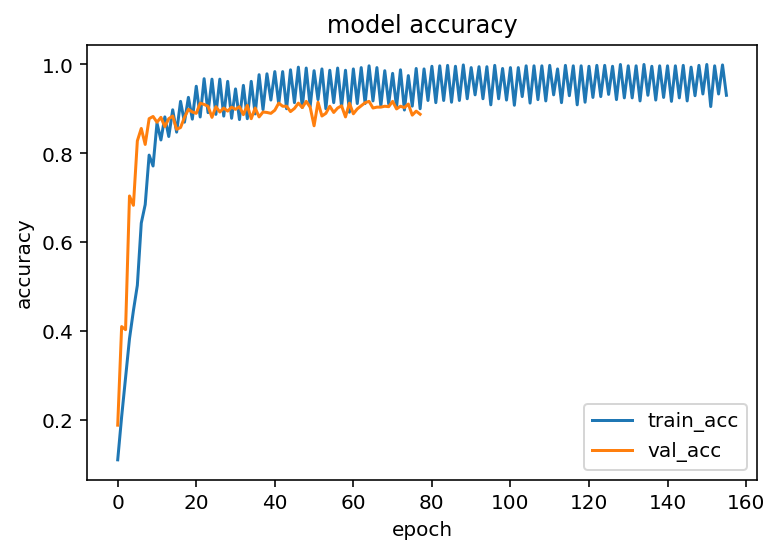

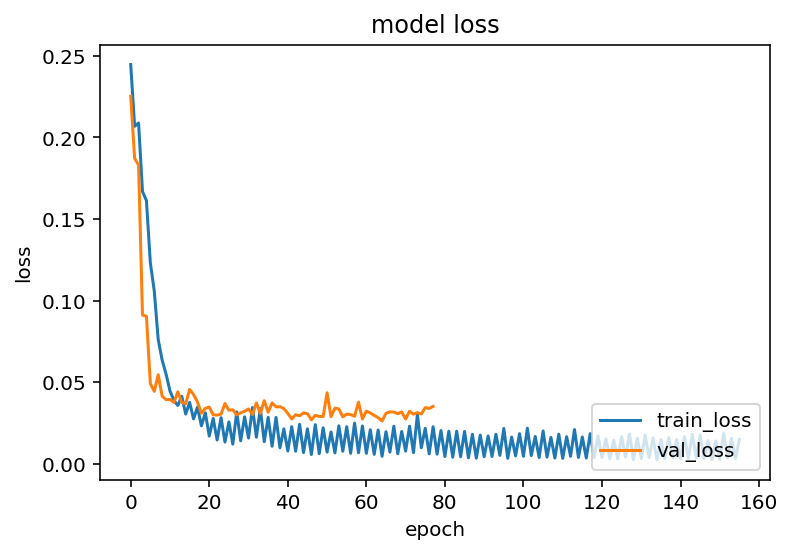

100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


In [49]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ratio_pl = 1.0 # ratio of train:pseudo
hard = True
ex_name = 'baseline_distill'
trial_times = 10

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results = {}
results['test_acc'] = np.empty((trial_times))
results['test_loss'] = np.empty((trial_times))
results['unlabeled_acc'] = np.empty((trial_times))
results['unlabeled_loss'] = np.empty((trial_times))
for i in range(trial_times):
    main_train_dataset = MNISTDataset(X_train, y_train, transform)
    main_train_loader = torch.utils.data.DataLoader(
        main_train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    sub_train_dataset = MNISTDataset(X_unlabeled, y_pseudo, transform)
    sub_train_loader = torch.utils.data.DataLoader(
        sub_train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_dataset = MNISTDataset(X_unlabeled, y_unlabeled, transform)
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, main_train_loader, sub_train_loader, criterion, optimizer, tracker, T=1)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results['test_acc'][i], results['test_loss'][i] = _test(model, test_loader, criterion)
    results['unlabeled_acc'][i], results['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion, unlabeled=True)

In [50]:
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results['test_acc']),
    np.std(results['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results['test_loss']),
    np.std(results['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results['unlabeled_acc']),
    np.std(results['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results['unlabeled_loss']),
    np.std(results['unlabeled_loss'])
))

[2017-12-06 14:01:02,445 INFO] Test Accuracy: 0.9219 ± 0.0044
[2017-12-06 14:01:02,448 INFO] Test Loss: 0.0251 ± 0.0014

[2017-12-06 14:01:02,450 INFO] Unlabeled Accuracy: 0.9310 ± 0.0042
[2017-12-06 14:01:02,452 INFO] Unlabeled Loss: 0.0227 ± 0.0012


In [ ]:
from scipy import stats

t, p = stats.ttest_ind(results['test_acc'], results['unlabeled_acc'], equal_var=False)
print( "Test accとUnlabeled acc(Pseudo Labelingされたデータの予測精度)に有意差はあるか？：p値 = %(p)s" %locals() )

t, p = stats.ttest_ind_from_stats(
    np.mean(results['test_acc']),
    np.std(results['test_acc']),
    10,
    0.8922, # supervised result
    0.0094, # //
    10,
    equal_var=False
)
print( "Pseudo Label使用/未使用に有意差はあるか？：p値 = %(p)s" %locals() )

## Soft Pseudo Label

### Pseudo-Label Temperature parameter

In [70]:
y_pseudo = np.load('./save/pseudo_label_T_2.npy')

X_unlabeled = X_test[:58000]
y_unlabeled = y_test[:58000]
y_pseudo = y_pseudo[:58000]
X_test = X_test[58000:]
y_test = y_test[58000:]

print(X_unlabeled.shape, y_unlabeled.shape, y_pseudo.shape, X_test.shape, y_test.shape)

(58000, 28, 28, 1) (58000, 10) (58000, 10) (10000, 28, 28, 1) (10000, 10)


[2017-12-07 22:57:29,656 INFO] Epoch: 0 | TrainAcc: 0.1270 | TrainLoss: 0.2496
[2017-12-07 22:57:30,383 INFO] Epoch: 0 | TrainAcc: 0.2383 | TrainLoss: 0.3360
[2017-12-07 22:57:30,837 INFO] Epoch: 0 | ValAcc: 0.2200 | ValLoss: 0.2198 

[2017-12-07 22:57:31,627 INFO] Epoch: 1 | TrainAcc: 0.2430 | TrainLoss: 0.2053
[2017-12-07 22:57:32,343 INFO] Epoch: 1 | TrainAcc: 0.3984 | TrainLoss: 0.2505
[2017-12-07 22:57:32,714 INFO] Epoch: 1 | ValAcc: 0.4710 | ValLoss: 0.1632 

[2017-12-07 22:57:33,408 INFO] Epoch: 2 | TrainAcc: 0.5710 | TrainLoss: 0.1369
[2017-12-07 22:57:34,091 INFO] Epoch: 2 | TrainAcc: 0.5674 | TrainLoss: 0.1669
[2017-12-07 22:57:34,459 INFO] Epoch: 2 | ValAcc: 0.6710 | ValLoss: 0.1256 

[2017-12-07 22:57:35,234 INFO] Epoch: 3 | TrainAcc: 0.6240 | TrainLoss: 0.1240
[2017-12-07 22:57:35,984 INFO] Epoch: 3 | TrainAcc: 0.6729 | TrainLoss: 0.1267
[2017-12-07 22:57:36,363 INFO] Epoch: 3 | ValAcc: 0.7010 | ValLoss: 0.0876 

[2017-12-07 22:57:37,084 INFO] Epoch: 4 | TrainAcc: 0.7010 |

[2017-12-07 22:58:30,595 INFO] Epoch: 34 | ValAcc: 0.9010 | ValLoss: 0.0354 

[2017-12-07 22:58:31,261 INFO] Epoch: 35 | TrainAcc: 0.9640 | TrainLoss: 0.0184
[2017-12-07 22:58:31,886 INFO] Epoch: 35 | TrainAcc: 0.8672 | TrainLoss: 0.0436
[2017-12-07 22:58:32,243 INFO] Epoch: 35 | ValAcc: 0.9070 | ValLoss: 0.0361 

[2017-12-07 22:58:32,914 INFO] Epoch: 36 | TrainAcc: 0.9800 | TrainLoss: 0.0168
[2017-12-07 22:58:33,579 INFO] Epoch: 36 | TrainAcc: 0.8916 | TrainLoss: 0.0411
[2017-12-07 22:58:33,945 INFO] Epoch: 36 | ValAcc: 0.9160 | ValLoss: 0.0336 

[2017-12-07 22:58:34,631 INFO] Epoch: 37 | TrainAcc: 0.9630 | TrainLoss: 0.0180
[2017-12-07 22:58:35,284 INFO] Epoch: 37 | TrainAcc: 0.8965 | TrainLoss: 0.0364
[2017-12-07 22:58:35,653 INFO] Epoch: 37 | ValAcc: 0.9120 | ValLoss: 0.0349 

[2017-12-07 22:58:36,356 INFO] Epoch: 38 | TrainAcc: 0.9700 | TrainLoss: 0.0162
[2017-12-07 22:58:36,994 INFO] Epoch: 38 | TrainAcc: 0.8887 | TrainLoss: 0.0433
[2017-12-07 22:58:37,367 INFO] Epoch: 38 | ValAc

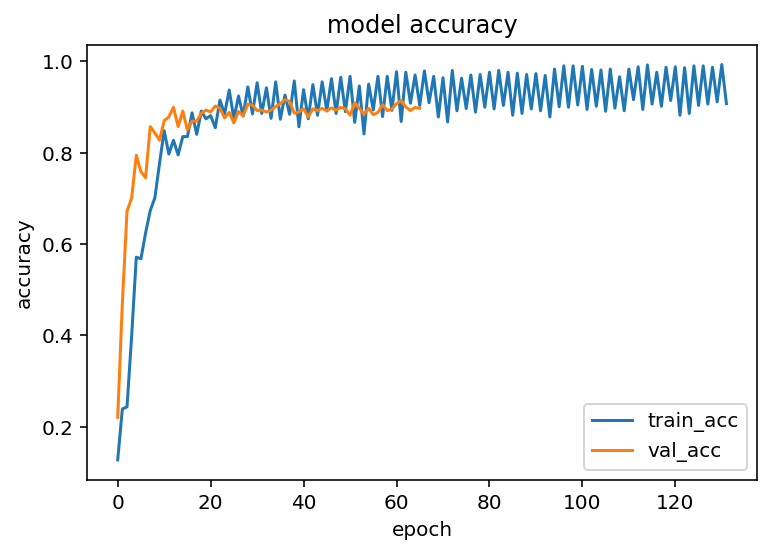

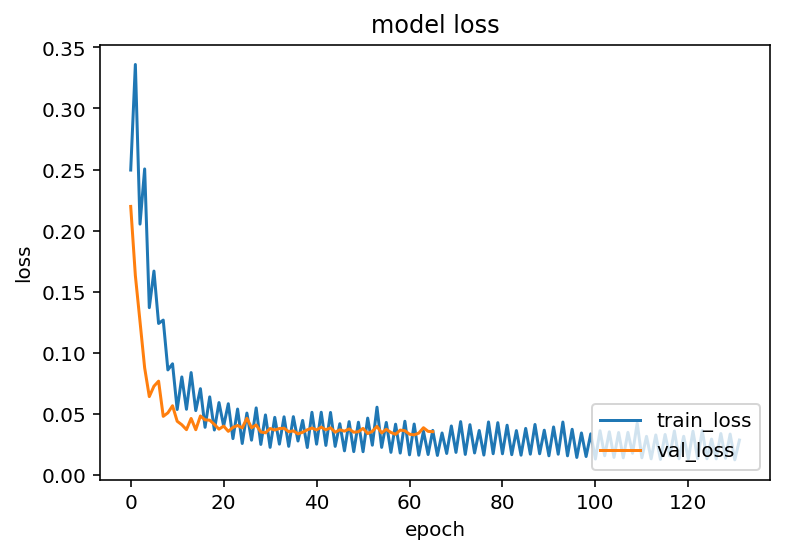

100%|██████████| 114/114 [00:11<00:00,  9.84it/s]
[2017-12-07 22:59:38,514 INFO] Epoch: 0 | TrainAcc: 0.1100 | TrainLoss: 0.2384
[2017-12-07 22:59:39,153 INFO] Epoch: 0 | TrainAcc: 0.2402 | TrainLoss: 0.3307
[2017-12-07 22:59:39,517 INFO] Epoch: 0 | ValAcc: 0.1380 | ValLoss: 0.2203 

[2017-12-07 22:59:40,201 INFO] Epoch: 1 | TrainAcc: 0.4050 | TrainLoss: 0.1937
[2017-12-07 22:59:40,832 INFO] Epoch: 1 | TrainAcc: 0.4697 | TrainLoss: 0.2300
[2017-12-07 22:59:41,208 INFO] Epoch: 1 | ValAcc: 0.1910 | ValLoss: 0.2842 

[2017-12-07 22:59:41,874 INFO] Epoch: 2 | TrainAcc: 0.5440 | TrainLoss: 0.1420
[2017-12-07 22:59:42,503 INFO] Epoch: 2 | TrainAcc: 0.6689 | TrainLoss: 0.1499
[2017-12-07 22:59:42,858 INFO] Epoch: 2 | ValAcc: 0.5920 | ValLoss: 0.1372 

[2017-12-07 22:59:43,570 INFO] Epoch: 3 | TrainAcc: 0.6970 | TrainLoss: 0.0932
[2017-12-07 22:59:44,190 INFO] Epoch: 3 | TrainAcc: 0.7305 | TrainLoss: 0.1101
[2017-12-07 22:59:44,555 INFO] Epoch: 3 | ValAcc: 0.6880 | ValLoss: 0.1082 

[2017-12-0

[2017-12-07 23:00:37,867 INFO] Epoch: 34 | TrainAcc: 0.8936 | TrainLoss: 0.0350
[2017-12-07 23:00:38,244 INFO] Epoch: 34 | ValAcc: 0.8970 | ValLoss: 0.0359 

[2017-12-07 23:00:39,064 INFO] Epoch: 35 | TrainAcc: 0.9780 | TrainLoss: 0.0148
[2017-12-07 23:00:39,728 INFO] Epoch: 35 | TrainAcc: 0.8965 | TrainLoss: 0.0322
[2017-12-07 23:00:40,168 INFO] Epoch: 35 | ValAcc: 0.9140 | ValLoss: 0.0317 

[2017-12-07 23:00:40,937 INFO] Epoch: 36 | TrainAcc: 0.9840 | TrainLoss: 0.0153
[2017-12-07 23:00:41,612 INFO] Epoch: 36 | TrainAcc: 0.9180 | TrainLoss: 0.0307
[2017-12-07 23:00:42,005 INFO] Epoch: 36 | ValAcc: 0.8980 | ValLoss: 0.0355 

[2017-12-07 23:00:42,705 INFO] Epoch: 37 | TrainAcc: 0.9840 | TrainLoss: 0.0139
[2017-12-07 23:00:43,417 INFO] Epoch: 37 | TrainAcc: 0.9062 | TrainLoss: 0.0314
[2017-12-07 23:00:43,892 INFO] Epoch: 37 | ValAcc: 0.8880 | ValLoss: 0.0381 

[2017-12-07 23:00:44,631 INFO] Epoch: 38 | TrainAcc: 0.9880 | TrainLoss: 0.0133
[2017-12-07 23:00:45,567 INFO] Epoch: 38 | Train

[2017-12-07 23:01:42,592 INFO] Epoch: 69 | TrainAcc: 0.9970 | TrainLoss: 0.0103
[2017-12-07 23:01:43,251 INFO] Epoch: 69 | TrainAcc: 0.9160 | TrainLoss: 0.0243
[2017-12-07 23:01:43,643 INFO] Epoch: 69 | ValAcc: 0.9040 | ValLoss: 0.0343 

[2017-12-07 23:01:44,371 INFO] Epoch: 70 | TrainAcc: 0.9960 | TrainLoss: 0.0108
[2017-12-07 23:01:45,040 INFO] Epoch: 70 | TrainAcc: 0.9053 | TrainLoss: 0.0260
[2017-12-07 23:01:45,436 INFO] Epoch: 70 | ValAcc: 0.9050 | ValLoss: 0.0348 

[2017-12-07 23:01:46,229 INFO] Epoch: 71 | TrainAcc: 0.9950 | TrainLoss: 0.0103
[2017-12-07 23:01:46,947 INFO] Epoch: 71 | TrainAcc: 0.9199 | TrainLoss: 0.0228
[2017-12-07 23:01:47,333 INFO] Epoch: 71 | ValAcc: 0.9100 | ValLoss: 0.0334 

[2017-12-07 23:01:48,154 INFO] Epoch: 72 | TrainAcc: 0.9960 | TrainLoss: 0.0097
[2017-12-07 23:01:48,832 INFO] Epoch: 72 | TrainAcc: 0.9248 | TrainLoss: 0.0236
[2017-12-07 23:01:49,231 INFO] Epoch: 72 | ValAcc: 0.8900 | ValLoss: 0.0376 

[2017-12-07 23:01:49,940 INFO] Epoch: 73 | Train

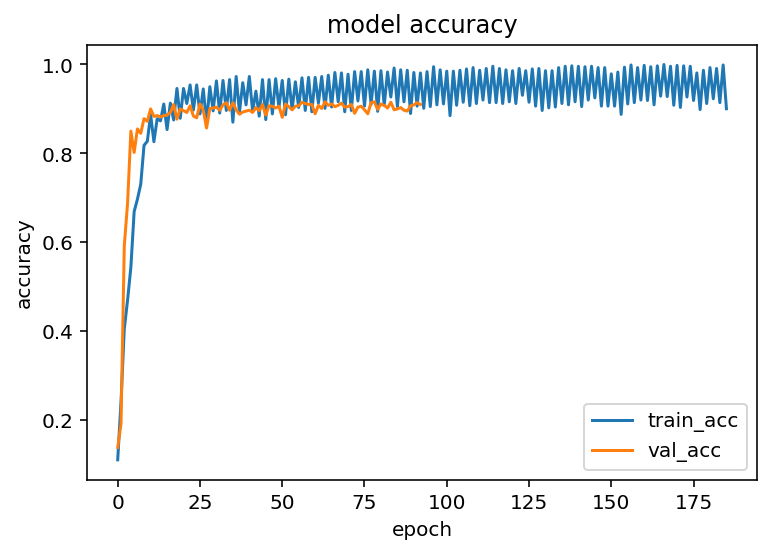

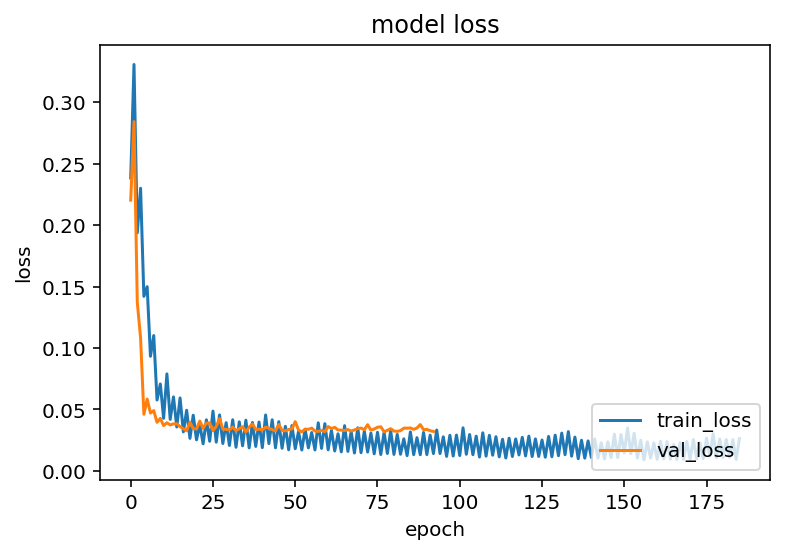

100%|██████████| 114/114 [00:12<00:00,  8.87it/s]
[2017-12-07 23:02:43,994 INFO] Epoch: 0 | TrainAcc: 0.1310 | TrainLoss: 0.2389
[2017-12-07 23:02:44,656 INFO] Epoch: 0 | TrainAcc: 0.1992 | TrainLoss: 0.3208
[2017-12-07 23:02:45,025 INFO] Epoch: 0 | ValAcc: 0.2870 | ValLoss: 0.2108 

[2017-12-07 23:02:45,765 INFO] Epoch: 1 | TrainAcc: 0.4290 | TrainLoss: 0.1795
[2017-12-07 23:02:46,463 INFO] Epoch: 1 | TrainAcc: 0.5371 | TrainLoss: 0.1886
[2017-12-07 23:02:46,846 INFO] Epoch: 1 | ValAcc: 0.5210 | ValLoss: 0.1262 

[2017-12-07 23:02:47,529 INFO] Epoch: 2 | TrainAcc: 0.6570 | TrainLoss: 0.1025
[2017-12-07 23:02:48,183 INFO] Epoch: 2 | TrainAcc: 0.7012 | TrainLoss: 0.1291
[2017-12-07 23:02:48,593 INFO] Epoch: 2 | ValAcc: 0.5890 | ValLoss: 0.1419 

[2017-12-07 23:02:49,596 INFO] Epoch: 3 | TrainAcc: 0.7370 | TrainLoss: 0.0785
[2017-12-07 23:02:50,571 INFO] Epoch: 3 | TrainAcc: 0.7344 | TrainLoss: 0.0999
[2017-12-07 23:02:51,033 INFO] Epoch: 3 | ValAcc: 0.7350 | ValLoss: 0.0948 

[2017-12-0

[2017-12-07 23:03:50,016 INFO] Epoch: 34 | TrainAcc: 0.9111 | TrainLoss: 0.0398
[2017-12-07 23:03:50,482 INFO] Epoch: 34 | ValAcc: 0.9100 | ValLoss: 0.0326 

[2017-12-07 23:03:51,289 INFO] Epoch: 35 | TrainAcc: 0.9810 | TrainLoss: 0.0158
[2017-12-07 23:03:52,011 INFO] Epoch: 35 | TrainAcc: 0.8906 | TrainLoss: 0.0407
[2017-12-07 23:03:52,411 INFO] Epoch: 35 | ValAcc: 0.9150 | ValLoss: 0.0342 

[2017-12-07 23:03:53,172 INFO] Epoch: 36 | TrainAcc: 0.9720 | TrainLoss: 0.0177
[2017-12-07 23:03:54,155 INFO] Epoch: 36 | TrainAcc: 0.8867 | TrainLoss: 0.0410
[2017-12-07 23:03:54,638 INFO] Epoch: 36 | ValAcc: 0.8740 | ValLoss: 0.0419 

[2017-12-07 23:03:55,415 INFO] Epoch: 37 | TrainAcc: 0.9690 | TrainLoss: 0.0191
[2017-12-07 23:03:56,204 INFO] Epoch: 37 | TrainAcc: 0.8984 | TrainLoss: 0.0377
[2017-12-07 23:03:56,653 INFO] Epoch: 37 | ValAcc: 0.9050 | ValLoss: 0.0337 

[2017-12-07 23:03:57,421 INFO] Epoch: 38 | TrainAcc: 0.9660 | TrainLoss: 0.0173
[2017-12-07 23:03:58,107 INFO] Epoch: 38 | Train

[2017-12-07 23:04:59,839 INFO] Epoch: 69 | TrainAcc: 0.9980 | TrainLoss: 0.0105
[2017-12-07 23:05:00,482 INFO] Epoch: 69 | TrainAcc: 0.9336 | TrainLoss: 0.0264
[2017-12-07 23:05:00,849 INFO] Epoch: 69 | ValAcc: 0.9160 | ValLoss: 0.0302 

[2017-12-07 23:05:01,526 INFO] Epoch: 70 | TrainAcc: 0.9970 | TrainLoss: 0.0097
[2017-12-07 23:05:02,177 INFO] Epoch: 70 | TrainAcc: 0.9229 | TrainLoss: 0.0269
[2017-12-07 23:05:02,539 INFO] Epoch: 70 | ValAcc: 0.9090 | ValLoss: 0.0326 

[2017-12-07 23:05:03,273 INFO] Epoch: 71 | TrainAcc: 0.9950 | TrainLoss: 0.0104
[2017-12-07 23:05:03,922 INFO] Epoch: 71 | TrainAcc: 0.9023 | TrainLoss: 0.0278
[2017-12-07 23:05:04,296 INFO] Epoch: 71 | ValAcc: 0.9140 | ValLoss: 0.0321 

[2017-12-07 23:05:04,995 INFO] Epoch: 72 | TrainAcc: 0.9980 | TrainLoss: 0.0106
[2017-12-07 23:05:05,638 INFO] Epoch: 72 | TrainAcc: 0.9170 | TrainLoss: 0.0268
[2017-12-07 23:05:06,006 INFO] Epoch: 72 | ValAcc: 0.9210 | ValLoss: 0.0303 

[2017-12-07 23:05:06,709 INFO] Epoch: 73 | Train

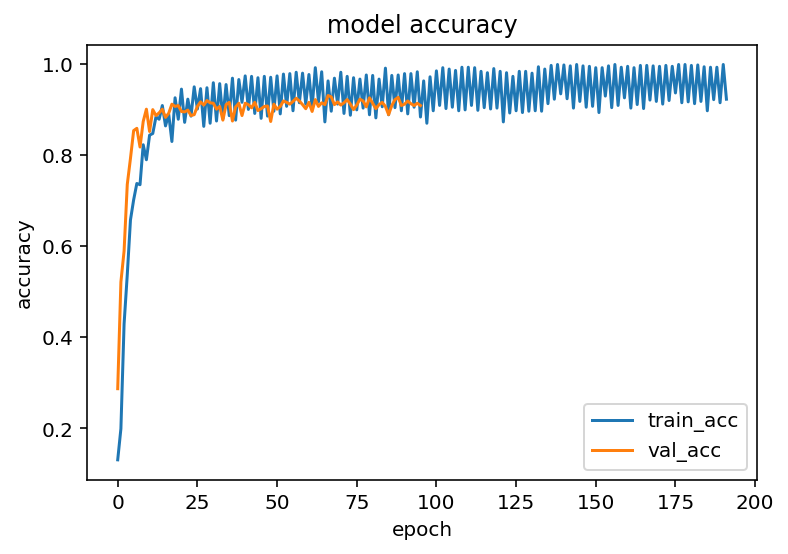

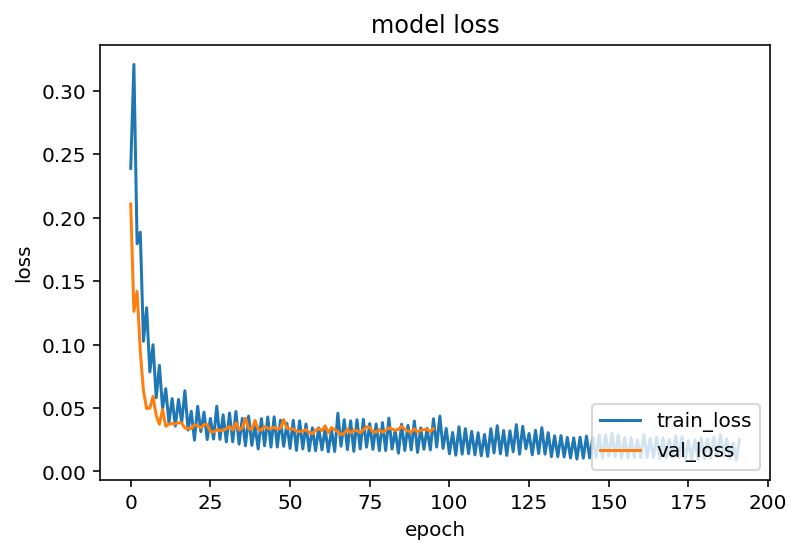

100%|██████████| 114/114 [00:12<00:00,  8.89it/s]
[2017-12-07 23:06:06,242 INFO] Epoch: 0 | TrainAcc: 0.1410 | TrainLoss: 0.2355
[2017-12-07 23:06:06,995 INFO] Epoch: 0 | TrainAcc: 0.2402 | TrainLoss: 0.3180
[2017-12-07 23:06:07,368 INFO] Epoch: 0 | ValAcc: 0.1310 | ValLoss: 0.2139 

[2017-12-07 23:06:08,062 INFO] Epoch: 1 | TrainAcc: 0.3240 | TrainLoss: 0.1967
[2017-12-07 23:06:08,724 INFO] Epoch: 1 | TrainAcc: 0.4180 | TrainLoss: 0.2376
[2017-12-07 23:06:09,105 INFO] Epoch: 1 | ValAcc: 0.4870 | ValLoss: 0.1529 

[2017-12-07 23:06:09,794 INFO] Epoch: 2 | TrainAcc: 0.5470 | TrainLoss: 0.1366
[2017-12-07 23:06:10,492 INFO] Epoch: 2 | TrainAcc: 0.6230 | TrainLoss: 0.1569
[2017-12-07 23:06:10,890 INFO] Epoch: 2 | ValAcc: 0.6390 | ValLoss: 0.1200 

[2017-12-07 23:06:11,592 INFO] Epoch: 3 | TrainAcc: 0.7060 | TrainLoss: 0.0933
[2017-12-07 23:06:12,290 INFO] Epoch: 3 | TrainAcc: 0.7217 | TrainLoss: 0.1085
[2017-12-07 23:06:12,724 INFO] Epoch: 3 | ValAcc: 0.7360 | ValLoss: 0.0803 

[2017-12-0

[2017-12-07 23:07:09,626 INFO] Epoch: 34 | TrainAcc: 0.8936 | TrainLoss: 0.0318
[2017-12-07 23:07:10,003 INFO] Epoch: 34 | ValAcc: 0.9020 | ValLoss: 0.0344 

[2017-12-07 23:07:10,702 INFO] Epoch: 35 | TrainAcc: 0.9880 | TrainLoss: 0.0135
[2017-12-07 23:07:11,352 INFO] Epoch: 35 | TrainAcc: 0.8984 | TrainLoss: 0.0349
[2017-12-07 23:07:11,713 INFO] Epoch: 35 | ValAcc: 0.9050 | ValLoss: 0.0349 

[2017-12-07 23:07:12,414 INFO] Epoch: 36 | TrainAcc: 0.9780 | TrainLoss: 0.0157
[2017-12-07 23:07:13,065 INFO] Epoch: 36 | TrainAcc: 0.9082 | TrainLoss: 0.0309
[2017-12-07 23:07:13,463 INFO] Epoch: 36 | ValAcc: 0.8950 | ValLoss: 0.0366 

[2017-12-07 23:07:14,164 INFO] Epoch: 37 | TrainAcc: 0.9790 | TrainLoss: 0.0148
[2017-12-07 23:07:14,812 INFO] Epoch: 37 | TrainAcc: 0.8867 | TrainLoss: 0.0402
[2017-12-07 23:07:15,172 INFO] Epoch: 37 | ValAcc: 0.9100 | ValLoss: 0.0319 

[2017-12-07 23:07:15,892 INFO] Epoch: 38 | TrainAcc: 0.9810 | TrainLoss: 0.0146
[2017-12-07 23:07:16,552 INFO] Epoch: 38 | Train

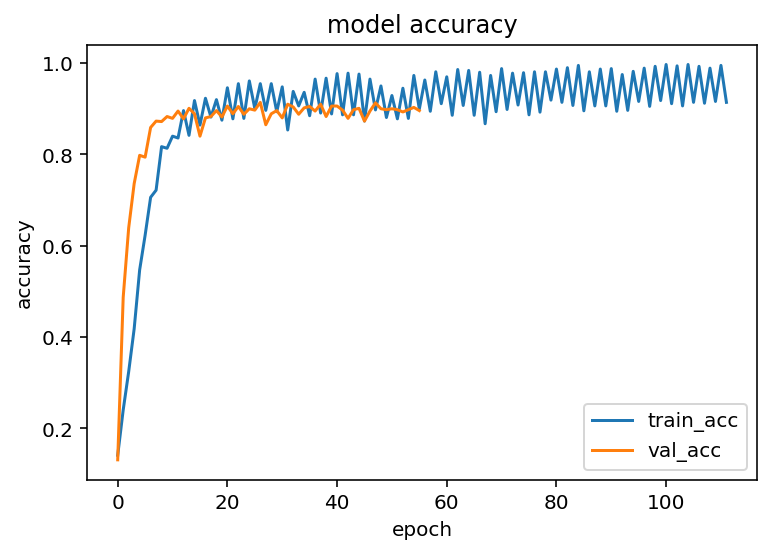

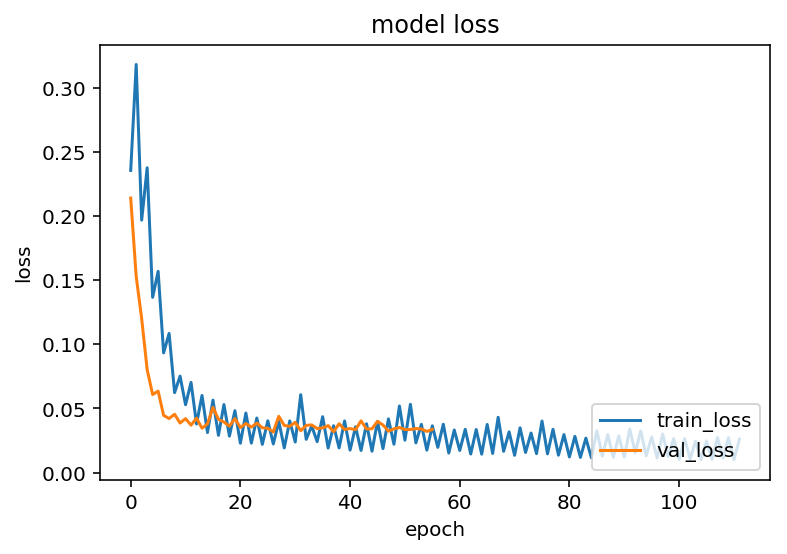

100%|██████████| 114/114 [00:11<00:00, 10.00it/s]
[2017-12-07 23:08:00,816 INFO] Epoch: 0 | TrainAcc: 0.1090 | TrainLoss: 0.2409
[2017-12-07 23:08:01,485 INFO] Epoch: 0 | TrainAcc: 0.2744 | TrainLoss: 0.3216
[2017-12-07 23:08:01,856 INFO] Epoch: 0 | ValAcc: 0.3730 | ValLoss: 0.2081 

[2017-12-07 23:08:02,548 INFO] Epoch: 1 | TrainAcc: 0.3800 | TrainLoss: 0.1844
[2017-12-07 23:08:03,221 INFO] Epoch: 1 | TrainAcc: 0.4883 | TrainLoss: 0.2135
[2017-12-07 23:08:03,582 INFO] Epoch: 1 | ValAcc: 0.2560 | ValLoss: 0.2010 

[2017-12-07 23:08:04,305 INFO] Epoch: 2 | TrainAcc: 0.6000 | TrainLoss: 0.1223
[2017-12-07 23:08:04,952 INFO] Epoch: 2 | TrainAcc: 0.4805 | TrainLoss: 0.2942
[2017-12-07 23:08:05,324 INFO] Epoch: 2 | ValAcc: 0.4610 | ValLoss: 0.2967 

[2017-12-07 23:08:06,013 INFO] Epoch: 3 | TrainAcc: 0.5320 | TrainLoss: 0.2449
[2017-12-07 23:08:06,691 INFO] Epoch: 3 | TrainAcc: 0.5371 | TrainLoss: 0.2139
[2017-12-07 23:08:07,066 INFO] Epoch: 3 | ValAcc: 0.4300 | ValLoss: 0.1651 

[2017-12-0

[2017-12-07 23:09:00,139 INFO] Epoch: 34 | TrainAcc: 0.9180 | TrainLoss: 0.0299
[2017-12-07 23:09:00,503 INFO] Epoch: 34 | ValAcc: 0.9000 | ValLoss: 0.0340 

[2017-12-07 23:09:01,201 INFO] Epoch: 35 | TrainAcc: 0.9820 | TrainLoss: 0.0153
[2017-12-07 23:09:01,844 INFO] Epoch: 35 | TrainAcc: 0.9014 | TrainLoss: 0.0316
[2017-12-07 23:09:02,205 INFO] Epoch: 35 | ValAcc: 0.9040 | ValLoss: 0.0340 

[2017-12-07 23:09:02,884 INFO] Epoch: 36 | TrainAcc: 0.9830 | TrainLoss: 0.0153
[2017-12-07 23:09:03,544 INFO] Epoch: 36 | TrainAcc: 0.9209 | TrainLoss: 0.0334
[2017-12-07 23:09:03,907 INFO] Epoch: 36 | ValAcc: 0.8990 | ValLoss: 0.0376 

[2017-12-07 23:09:04,625 INFO] Epoch: 37 | TrainAcc: 0.9700 | TrainLoss: 0.0179
[2017-12-07 23:09:05,293 INFO] Epoch: 37 | TrainAcc: 0.9043 | TrainLoss: 0.0354
[2017-12-07 23:09:05,668 INFO] Epoch: 37 | ValAcc: 0.9060 | ValLoss: 0.0342 

[2017-12-07 23:09:06,364 INFO] Epoch: 38 | TrainAcc: 0.9760 | TrainLoss: 0.0162
[2017-12-07 23:09:07,029 INFO] Epoch: 38 | Train

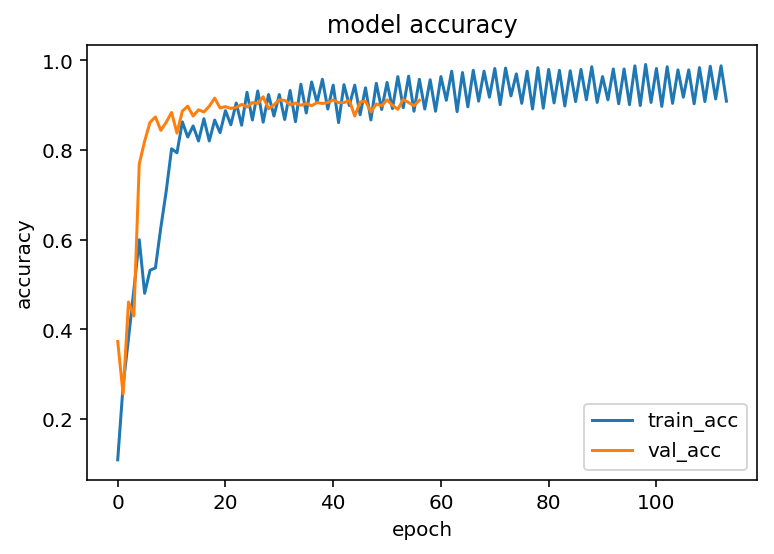

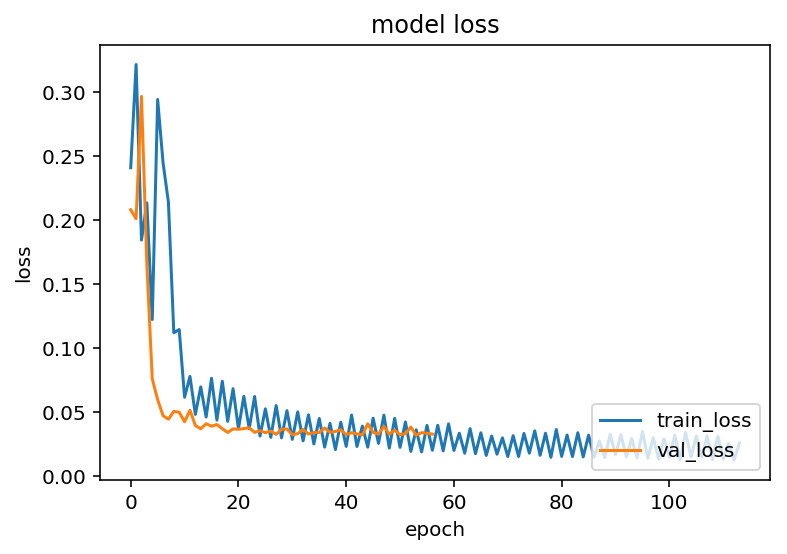

100%|██████████| 114/114 [00:11<00:00,  9.87it/s]
[2017-12-07 23:09:53,029 INFO] Epoch: 0 | TrainAcc: 0.1430 | TrainLoss: 0.2332
[2017-12-07 23:09:53,691 INFO] Epoch: 0 | TrainAcc: 0.2285 | TrainLoss: 0.3177
[2017-12-07 23:09:54,053 INFO] Epoch: 0 | ValAcc: 0.2100 | ValLoss: 0.2087 

[2017-12-07 23:09:54,735 INFO] Epoch: 1 | TrainAcc: 0.3700 | TrainLoss: 0.1812
[2017-12-07 23:09:55,397 INFO] Epoch: 1 | TrainAcc: 0.4453 | TrainLoss: 0.2293
[2017-12-07 23:09:55,756 INFO] Epoch: 1 | ValAcc: 0.2510 | ValLoss: 0.2269 

[2017-12-07 23:09:56,448 INFO] Epoch: 2 | TrainAcc: 0.4350 | TrainLoss: 0.1638
[2017-12-07 23:09:57,108 INFO] Epoch: 2 | TrainAcc: 0.6338 | TrainLoss: 0.1547
[2017-12-07 23:09:57,472 INFO] Epoch: 2 | ValAcc: 0.6260 | ValLoss: 0.1083 

[2017-12-07 23:09:58,145 INFO] Epoch: 3 | TrainAcc: 0.6870 | TrainLoss: 0.0888
[2017-12-07 23:09:58,789 INFO] Epoch: 3 | TrainAcc: 0.7314 | TrainLoss: 0.1044
[2017-12-07 23:09:59,159 INFO] Epoch: 3 | ValAcc: 0.7210 | ValLoss: 0.0823 

[2017-12-0

[2017-12-07 23:10:51,644 INFO] Epoch: 34 | TrainAcc: 0.9004 | TrainLoss: 0.0346
[2017-12-07 23:10:52,015 INFO] Epoch: 34 | ValAcc: 0.8990 | ValLoss: 0.0343 

[2017-12-07 23:10:52,712 INFO] Epoch: 35 | TrainAcc: 0.9920 | TrainLoss: 0.0136
[2017-12-07 23:10:53,364 INFO] Epoch: 35 | TrainAcc: 0.9141 | TrainLoss: 0.0312
[2017-12-07 23:10:53,735 INFO] Epoch: 35 | ValAcc: 0.9110 | ValLoss: 0.0321 

[2017-12-07 23:10:54,427 INFO] Epoch: 36 | TrainAcc: 0.9930 | TrainLoss: 0.0134
[2017-12-07 23:10:55,086 INFO] Epoch: 36 | TrainAcc: 0.8984 | TrainLoss: 0.0365
[2017-12-07 23:10:55,456 INFO] Epoch: 36 | ValAcc: 0.8870 | ValLoss: 0.0370 

[2017-12-07 23:10:56,167 INFO] Epoch: 37 | TrainAcc: 0.9830 | TrainLoss: 0.0154
[2017-12-07 23:10:56,807 INFO] Epoch: 37 | TrainAcc: 0.8984 | TrainLoss: 0.0333
[2017-12-07 23:10:57,181 INFO] Epoch: 37 | ValAcc: 0.9110 | ValLoss: 0.0321 

[2017-12-07 23:10:57,869 INFO] Epoch: 38 | TrainAcc: 0.9820 | TrainLoss: 0.0149
[2017-12-07 23:10:58,523 INFO] Epoch: 38 | Train

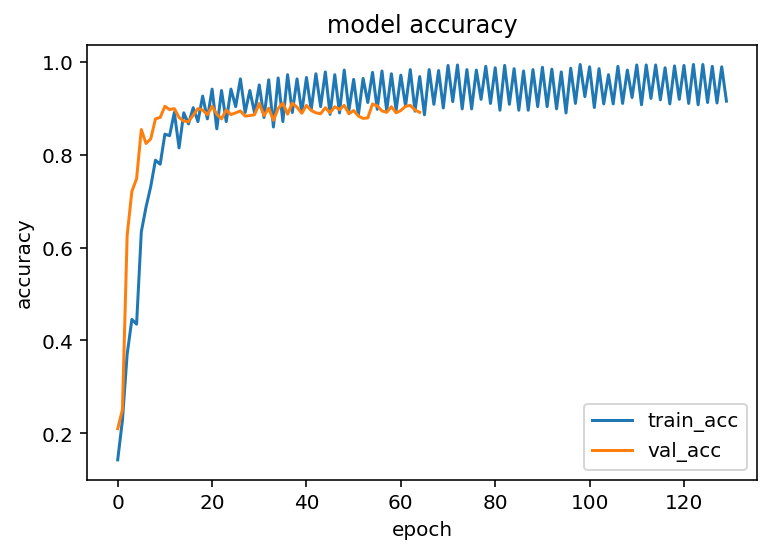

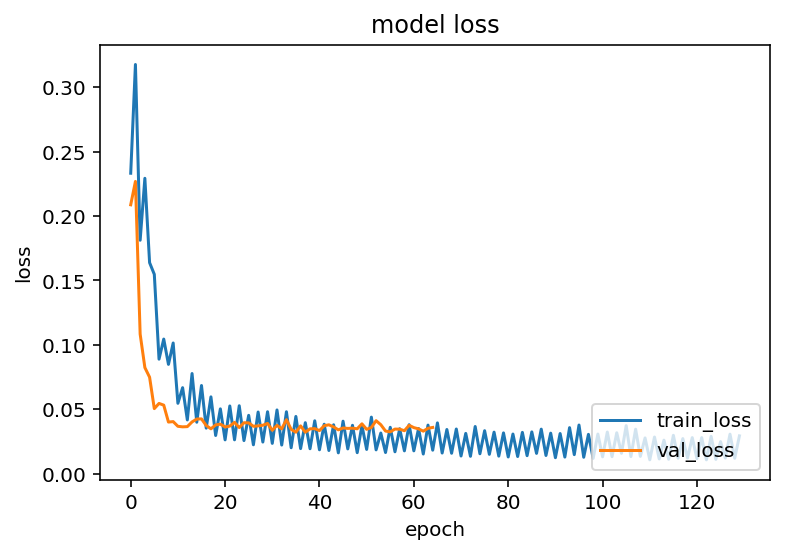

100%|██████████| 114/114 [00:11<00:00,  9.53it/s]
[2017-12-07 23:11:59,121 INFO] Epoch: 0 | TrainAcc: 0.1700 | TrainLoss: 0.2262
[2017-12-07 23:11:59,784 INFO] Epoch: 0 | TrainAcc: 0.2617 | TrainLoss: 0.3131
[2017-12-07 23:12:00,157 INFO] Epoch: 0 | ValAcc: 0.3610 | ValLoss: 0.2042 

[2017-12-07 23:12:00,840 INFO] Epoch: 1 | TrainAcc: 0.4030 | TrainLoss: 0.1755
[2017-12-07 23:12:01,487 INFO] Epoch: 1 | TrainAcc: 0.4727 | TrainLoss: 0.2190
[2017-12-07 23:12:01,853 INFO] Epoch: 1 | ValAcc: 0.4890 | ValLoss: 0.1355 

[2017-12-07 23:12:02,513 INFO] Epoch: 2 | TrainAcc: 0.5610 | TrainLoss: 0.1263
[2017-12-07 23:12:03,141 INFO] Epoch: 2 | TrainAcc: 0.7207 | TrainLoss: 0.1186
[2017-12-07 23:12:03,499 INFO] Epoch: 2 | ValAcc: 0.7140 | ValLoss: 0.0830 

[2017-12-07 23:12:04,184 INFO] Epoch: 3 | TrainAcc: 0.7850 | TrainLoss: 0.0667
[2017-12-07 23:12:04,813 INFO] Epoch: 3 | TrainAcc: 0.7920 | TrainLoss: 0.0948
[2017-12-07 23:12:05,165 INFO] Epoch: 3 | ValAcc: 0.7630 | ValLoss: 0.0722 

[2017-12-0

[2017-12-07 23:12:57,312 INFO] Epoch: 34 | TrainAcc: 0.9023 | TrainLoss: 0.0293
[2017-12-07 23:12:57,689 INFO] Epoch: 34 | ValAcc: 0.9070 | ValLoss: 0.0334 

[2017-12-07 23:12:58,371 INFO] Epoch: 35 | TrainAcc: 0.9730 | TrainLoss: 0.0143
[2017-12-07 23:12:59,020 INFO] Epoch: 35 | TrainAcc: 0.9023 | TrainLoss: 0.0368
[2017-12-07 23:12:59,388 INFO] Epoch: 35 | ValAcc: 0.8770 | ValLoss: 0.0407 

[2017-12-07 23:13:00,065 INFO] Epoch: 36 | TrainAcc: 0.9750 | TrainLoss: 0.0156
[2017-12-07 23:13:00,698 INFO] Epoch: 36 | TrainAcc: 0.8994 | TrainLoss: 0.0347
[2017-12-07 23:13:01,056 INFO] Epoch: 36 | ValAcc: 0.8700 | ValLoss: 0.0398 

[2017-12-07 23:13:01,754 INFO] Epoch: 37 | TrainAcc: 0.9750 | TrainLoss: 0.0162
[2017-12-07 23:13:02,414 INFO] Epoch: 37 | TrainAcc: 0.8975 | TrainLoss: 0.0305
[2017-12-07 23:13:02,781 INFO] Epoch: 37 | ValAcc: 0.9060 | ValLoss: 0.0351 

[2017-12-07 23:13:03,448 INFO] Epoch: 38 | TrainAcc: 0.9830 | TrainLoss: 0.0145
[2017-12-07 23:13:04,099 INFO] Epoch: 38 | Train

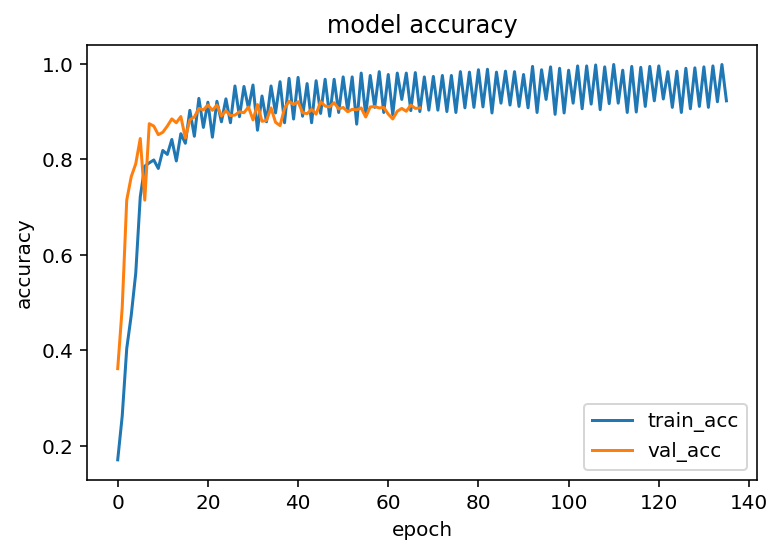

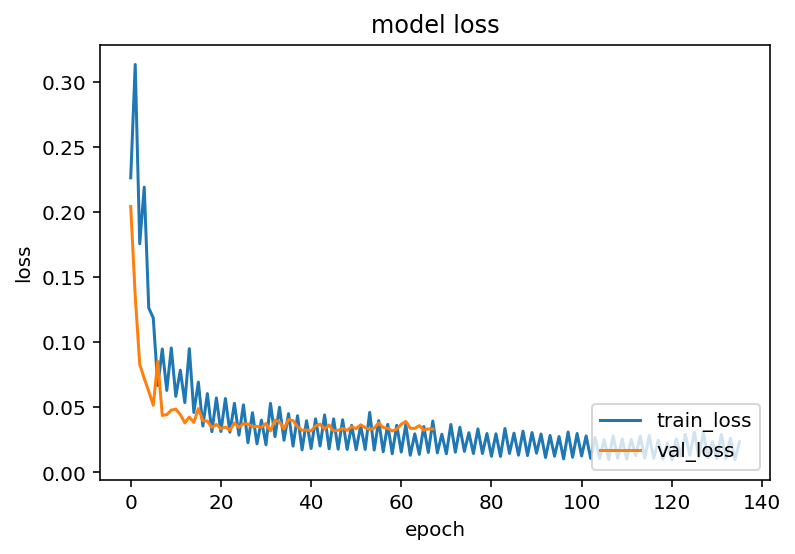

100%|██████████| 114/114 [00:11<00:00, 10.00it/s]
[2017-12-07 23:14:08,745 INFO] Epoch: 0 | TrainAcc: 0.1300 | TrainLoss: 0.2423
[2017-12-07 23:14:09,505 INFO] Epoch: 0 | TrainAcc: 0.1787 | TrainLoss: 0.3352
[2017-12-07 23:14:09,972 INFO] Epoch: 0 | ValAcc: 0.1230 | ValLoss: 0.2243 

[2017-12-07 23:14:10,778 INFO] Epoch: 1 | TrainAcc: 0.2340 | TrainLoss: 0.2086
[2017-12-07 23:14:11,545 INFO] Epoch: 1 | TrainAcc: 0.3574 | TrainLoss: 0.2652
[2017-12-07 23:14:12,007 INFO] Epoch: 1 | ValAcc: 0.3000 | ValLoss: 0.1827 

[2017-12-07 23:14:12,812 INFO] Epoch: 2 | TrainAcc: 0.5430 | TrainLoss: 0.1462
[2017-12-07 23:14:13,592 INFO] Epoch: 2 | TrainAcc: 0.4883 | TrainLoss: 0.1969
[2017-12-07 23:14:14,068 INFO] Epoch: 2 | ValAcc: 0.1900 | ValLoss: 0.3289 

[2017-12-07 23:14:14,868 INFO] Epoch: 3 | TrainAcc: 0.6150 | TrainLoss: 0.1083
[2017-12-07 23:14:15,655 INFO] Epoch: 3 | TrainAcc: 0.7480 | TrainLoss: 0.1063
[2017-12-07 23:14:16,122 INFO] Epoch: 3 | ValAcc: 0.7110 | ValLoss: 0.0787 

[2017-12-0

[2017-12-07 23:15:19,037 INFO] Epoch: 34 | TrainAcc: 0.9062 | TrainLoss: 0.0318
[2017-12-07 23:15:19,499 INFO] Epoch: 34 | ValAcc: 0.9020 | ValLoss: 0.0349 

[2017-12-07 23:15:20,319 INFO] Epoch: 35 | TrainAcc: 0.9760 | TrainLoss: 0.0149
[2017-12-07 23:15:21,082 INFO] Epoch: 35 | TrainAcc: 0.8916 | TrainLoss: 0.0378
[2017-12-07 23:15:21,545 INFO] Epoch: 35 | ValAcc: 0.9060 | ValLoss: 0.0346 

[2017-12-07 23:15:22,352 INFO] Epoch: 36 | TrainAcc: 0.9810 | TrainLoss: 0.0158
[2017-12-07 23:15:23,138 INFO] Epoch: 36 | TrainAcc: 0.9062 | TrainLoss: 0.0326
[2017-12-07 23:15:23,602 INFO] Epoch: 36 | ValAcc: 0.8890 | ValLoss: 0.0377 

[2017-12-07 23:15:24,411 INFO] Epoch: 37 | TrainAcc: 0.9670 | TrainLoss: 0.0158
[2017-12-07 23:15:25,181 INFO] Epoch: 37 | TrainAcc: 0.9180 | TrainLoss: 0.0295
[2017-12-07 23:15:25,640 INFO] Epoch: 37 | ValAcc: 0.9120 | ValLoss: 0.0308 

[2017-12-07 23:15:26,437 INFO] Epoch: 38 | TrainAcc: 0.9810 | TrainLoss: 0.0138
[2017-12-07 23:15:27,196 INFO] Epoch: 38 | Train

[2017-12-07 23:16:30,283 INFO] Epoch: 69 | TrainAcc: 0.9910 | TrainLoss: 0.0120
[2017-12-07 23:16:31,072 INFO] Epoch: 69 | TrainAcc: 0.9180 | TrainLoss: 0.0266
[2017-12-07 23:16:31,538 INFO] Epoch: 69 | ValAcc: 0.9050 | ValLoss: 0.0342 

[2017-12-07 23:16:32,355 INFO] Epoch: 70 | TrainAcc: 0.9930 | TrainLoss: 0.0108
[2017-12-07 23:16:33,123 INFO] Epoch: 70 | TrainAcc: 0.9209 | TrainLoss: 0.0239
[2017-12-07 23:16:33,602 INFO] Epoch: 70 | ValAcc: 0.9050 | ValLoss: 0.0332 

[2017-12-07 23:16:34,391 INFO] Epoch: 71 | TrainAcc: 0.9960 | TrainLoss: 0.0095
[2017-12-07 23:16:35,167 INFO] Epoch: 71 | TrainAcc: 0.9180 | TrainLoss: 0.0261
[2017-12-07 23:16:35,630 INFO] Epoch: 71 | ValAcc: 0.9050 | ValLoss: 0.0325 

[2017-12-07 23:16:36,425 INFO] Epoch: 72 | TrainAcc: 0.9870 | TrainLoss: 0.0120
[2017-12-07 23:16:37,212 INFO] Epoch: 72 | TrainAcc: 0.9004 | TrainLoss: 0.0310
[2017-12-07 23:16:37,693 INFO] Epoch: 72 | ValAcc: 0.9010 | ValLoss: 0.0346 

[2017-12-07 23:16:38,497 INFO] Epoch: 73 | Train

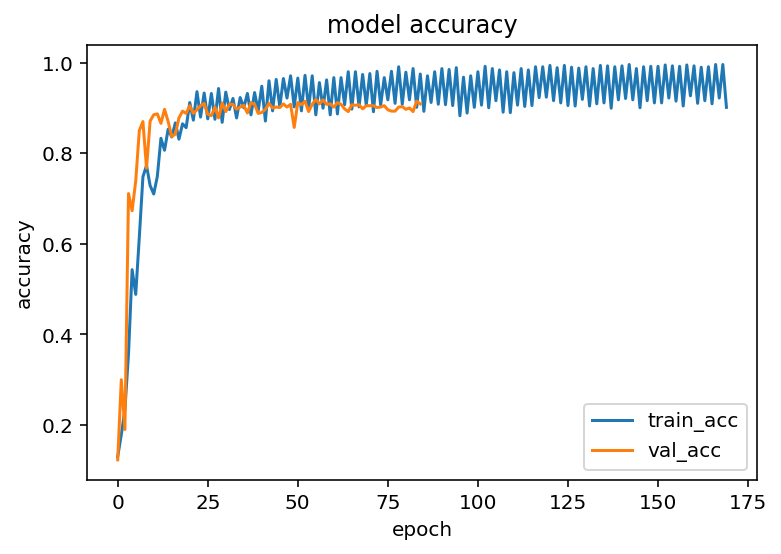

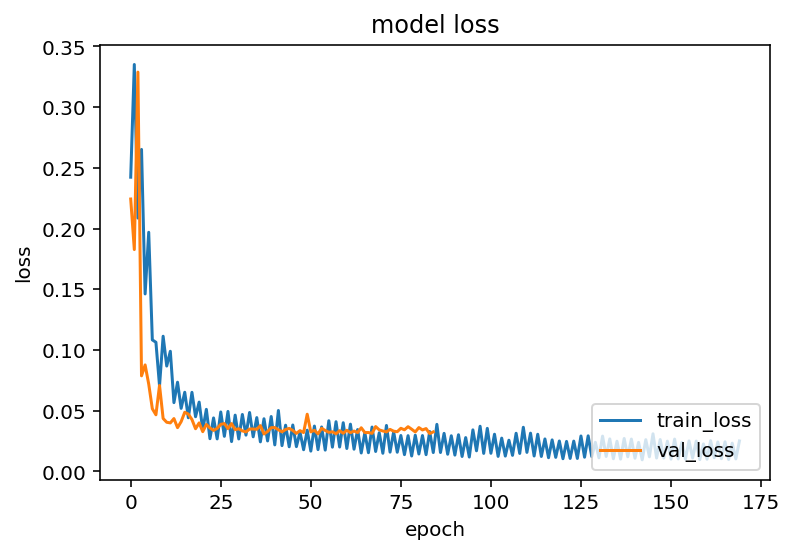

100%|██████████| 114/114 [00:11<00:00,  9.94it/s]
[2017-12-07 23:17:17,094 INFO] Epoch: 0 | TrainAcc: 0.1180 | TrainLoss: 0.2503
[2017-12-07 23:17:17,736 INFO] Epoch: 0 | TrainAcc: 0.1748 | TrainLoss: 0.3262
[2017-12-07 23:17:18,098 INFO] Epoch: 0 | ValAcc: 0.2020 | ValLoss: 0.2147 

[2017-12-07 23:17:18,759 INFO] Epoch: 1 | TrainAcc: 0.3520 | TrainLoss: 0.1943
[2017-12-07 23:17:19,411 INFO] Epoch: 1 | TrainAcc: 0.5303 | TrainLoss: 0.2098
[2017-12-07 23:17:19,782 INFO] Epoch: 1 | ValAcc: 0.4320 | ValLoss: 0.1445 

[2017-12-07 23:17:20,494 INFO] Epoch: 2 | TrainAcc: 0.5890 | TrainLoss: 0.1140
[2017-12-07 23:17:21,139 INFO] Epoch: 2 | TrainAcc: 0.6191 | TrainLoss: 0.1552
[2017-12-07 23:17:21,513 INFO] Epoch: 2 | ValAcc: 0.3310 | ValLoss: 0.3064 

[2017-12-07 23:17:22,220 INFO] Epoch: 3 | TrainAcc: 0.6810 | TrainLoss: 0.0991
[2017-12-07 23:17:22,862 INFO] Epoch: 3 | TrainAcc: 0.7549 | TrainLoss: 0.0974
[2017-12-07 23:17:23,217 INFO] Epoch: 3 | ValAcc: 0.6060 | ValLoss: 0.1224 

[2017-12-0

[2017-12-07 23:18:15,617 INFO] Epoch: 34 | TrainAcc: 0.9014 | TrainLoss: 0.0311
[2017-12-07 23:18:15,973 INFO] Epoch: 34 | ValAcc: 0.8950 | ValLoss: 0.0364 

[2017-12-07 23:18:16,679 INFO] Epoch: 35 | TrainAcc: 0.9830 | TrainLoss: 0.0143
[2017-12-07 23:18:17,325 INFO] Epoch: 35 | TrainAcc: 0.9150 | TrainLoss: 0.0281
[2017-12-07 23:18:17,691 INFO] Epoch: 35 | ValAcc: 0.8820 | ValLoss: 0.0363 

[2017-12-07 23:18:18,359 INFO] Epoch: 36 | TrainAcc: 0.9900 | TrainLoss: 0.0113
[2017-12-07 23:18:19,013 INFO] Epoch: 36 | TrainAcc: 0.9170 | TrainLoss: 0.0284
[2017-12-07 23:18:19,369 INFO] Epoch: 36 | ValAcc: 0.9000 | ValLoss: 0.0344 

[2017-12-07 23:18:20,072 INFO] Epoch: 37 | TrainAcc: 0.9880 | TrainLoss: 0.0119
[2017-12-07 23:18:20,721 INFO] Epoch: 37 | TrainAcc: 0.8975 | TrainLoss: 0.0304
[2017-12-07 23:18:21,083 INFO] Epoch: 37 | ValAcc: 0.8960 | ValLoss: 0.0338 

[2017-12-07 23:18:21,747 INFO] Epoch: 38 | TrainAcc: 0.9850 | TrainLoss: 0.0143
[2017-12-07 23:18:22,398 INFO] Epoch: 38 | Train

[2017-12-07 23:19:14,531 INFO] Epoch: 69 | TrainAcc: 0.9830 | TrainLoss: 0.0121
[2017-12-07 23:19:15,192 INFO] Epoch: 69 | TrainAcc: 0.9072 | TrainLoss: 0.0289
[2017-12-07 23:19:15,580 INFO] Epoch: 69 | ValAcc: 0.8820 | ValLoss: 0.0380 

[2017-12-07 23:19:16,252 INFO] Epoch: 70 | TrainAcc: 0.9850 | TrainLoss: 0.0125
[2017-12-07 23:19:16,895 INFO] Epoch: 70 | TrainAcc: 0.9111 | TrainLoss: 0.0263
[2017-12-07 23:19:17,261 INFO] Epoch: 70 | ValAcc: 0.8920 | ValLoss: 0.0356 

[2017-12-07 23:19:17,950 INFO] Epoch: 71 | TrainAcc: 0.9860 | TrainLoss: 0.0113
[2017-12-07 23:19:18,605 INFO] Epoch: 71 | TrainAcc: 0.8818 | TrainLoss: 0.0339
[2017-12-07 23:19:18,965 INFO] Epoch: 71 | ValAcc: 0.8890 | ValLoss: 0.0357 

[2017-12-07 23:19:19,667 INFO] Epoch: 72 | TrainAcc: 0.9660 | TrainLoss: 0.0165
[2017-12-07 23:19:20,330 INFO] Epoch: 72 | TrainAcc: 0.8779 | TrainLoss: 0.0383
[2017-12-07 23:19:20,700 INFO] Epoch: 72 | ValAcc: 0.9020 | ValLoss: 0.0327 

[2017-12-07 23:19:21,386 INFO] Epoch: 73 | Train

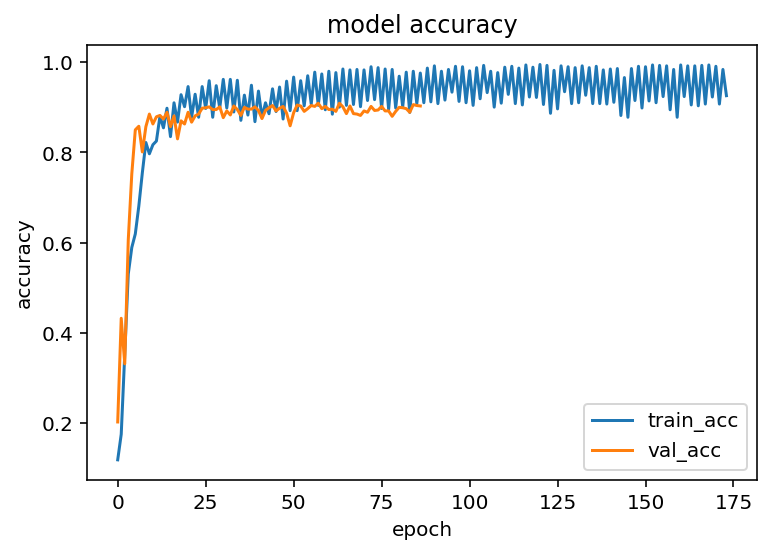

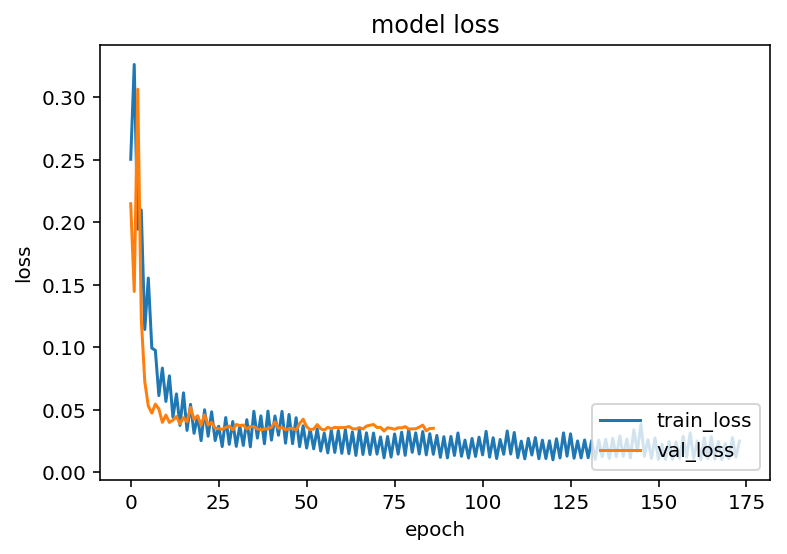

100%|██████████| 114/114 [00:11<00:00,  9.99it/s]
[2017-12-07 23:19:59,093 INFO] Epoch: 0 | TrainAcc: 0.1410 | TrainLoss: 0.2330
[2017-12-07 23:19:59,735 INFO] Epoch: 0 | TrainAcc: 0.2227 | TrainLoss: 0.3178
[2017-12-07 23:20:00,108 INFO] Epoch: 0 | ValAcc: 0.2040 | ValLoss: 0.2094 

[2017-12-07 23:20:00,794 INFO] Epoch: 1 | TrainAcc: 0.4640 | TrainLoss: 0.1713
[2017-12-07 23:20:01,438 INFO] Epoch: 1 | TrainAcc: 0.5430 | TrainLoss: 0.1702
[2017-12-07 23:20:01,800 INFO] Epoch: 1 | ValAcc: 0.4960 | ValLoss: 0.1312 

[2017-12-07 23:20:02,475 INFO] Epoch: 2 | TrainAcc: 0.5770 | TrainLoss: 0.1070
[2017-12-07 23:20:03,139 INFO] Epoch: 2 | TrainAcc: 0.5166 | TrainLoss: 0.2591
[2017-12-07 23:20:03,498 INFO] Epoch: 2 | ValAcc: 0.3970 | ValLoss: 0.2516 

[2017-12-07 23:20:04,197 INFO] Epoch: 3 | TrainAcc: 0.4770 | TrainLoss: 0.1639
[2017-12-07 23:20:04,845 INFO] Epoch: 3 | TrainAcc: 0.5938 | TrainLoss: 0.1612
[2017-12-07 23:20:05,206 INFO] Epoch: 3 | ValAcc: 0.7050 | ValLoss: 0.0893 

[2017-12-0

[2017-12-07 23:20:57,953 INFO] Epoch: 34 | TrainAcc: 0.8955 | TrainLoss: 0.0313
[2017-12-07 23:20:58,315 INFO] Epoch: 34 | ValAcc: 0.9000 | ValLoss: 0.0330 

[2017-12-07 23:20:58,986 INFO] Epoch: 35 | TrainAcc: 0.9830 | TrainLoss: 0.0130
[2017-12-07 23:20:59,641 INFO] Epoch: 35 | TrainAcc: 0.9102 | TrainLoss: 0.0263
[2017-12-07 23:21:00,003 INFO] Epoch: 35 | ValAcc: 0.9010 | ValLoss: 0.0328 

[2017-12-07 23:21:00,720 INFO] Epoch: 36 | TrainAcc: 0.9850 | TrainLoss: 0.0132
[2017-12-07 23:21:01,360 INFO] Epoch: 36 | TrainAcc: 0.9082 | TrainLoss: 0.0313
[2017-12-07 23:21:01,733 INFO] Epoch: 36 | ValAcc: 0.8920 | ValLoss: 0.0343 

[2017-12-07 23:21:02,408 INFO] Epoch: 37 | TrainAcc: 0.9860 | TrainLoss: 0.0122
[2017-12-07 23:21:03,057 INFO] Epoch: 37 | TrainAcc: 0.8965 | TrainLoss: 0.0317
[2017-12-07 23:21:03,439 INFO] Epoch: 37 | ValAcc: 0.9050 | ValLoss: 0.0323 

[2017-12-07 23:21:04,146 INFO] Epoch: 38 | TrainAcc: 0.9930 | TrainLoss: 0.0123
[2017-12-07 23:21:04,791 INFO] Epoch: 38 | Train

[2017-12-07 23:22:02,575 INFO] Epoch: 69 | TrainAcc: 0.9960 | TrainLoss: 0.0094
[2017-12-07 23:22:03,241 INFO] Epoch: 69 | TrainAcc: 0.9346 | TrainLoss: 0.0216
[2017-12-07 23:22:03,619 INFO] Epoch: 69 | ValAcc: 0.9040 | ValLoss: 0.0342 

[2017-12-07 23:22:04,301 INFO] Epoch: 70 | TrainAcc: 0.9950 | TrainLoss: 0.0102
[2017-12-07 23:22:05,012 INFO] Epoch: 70 | TrainAcc: 0.9092 | TrainLoss: 0.0267
[2017-12-07 23:22:05,381 INFO] Epoch: 70 | ValAcc: 0.8950 | ValLoss: 0.0348 

[2017-12-07 23:22:06,099 INFO] Epoch: 71 | TrainAcc: 0.9900 | TrainLoss: 0.0115
[2017-12-07 23:22:06,743 INFO] Epoch: 71 | TrainAcc: 0.9170 | TrainLoss: 0.0274
[2017-12-07 23:22:07,118 INFO] Epoch: 71 | ValAcc: 0.9050 | ValLoss: 0.0312 

[2017-12-07 23:22:07,799 INFO] Epoch: 72 | TrainAcc: 0.9940 | TrainLoss: 0.0107
[2017-12-07 23:22:08,456 INFO] Epoch: 72 | TrainAcc: 0.9160 | TrainLoss: 0.0263
[2017-12-07 23:22:08,829 INFO] Epoch: 72 | ValAcc: 0.9070 | ValLoss: 0.0332 

[2017-12-07 23:22:09,542 INFO] Epoch: 73 | Train

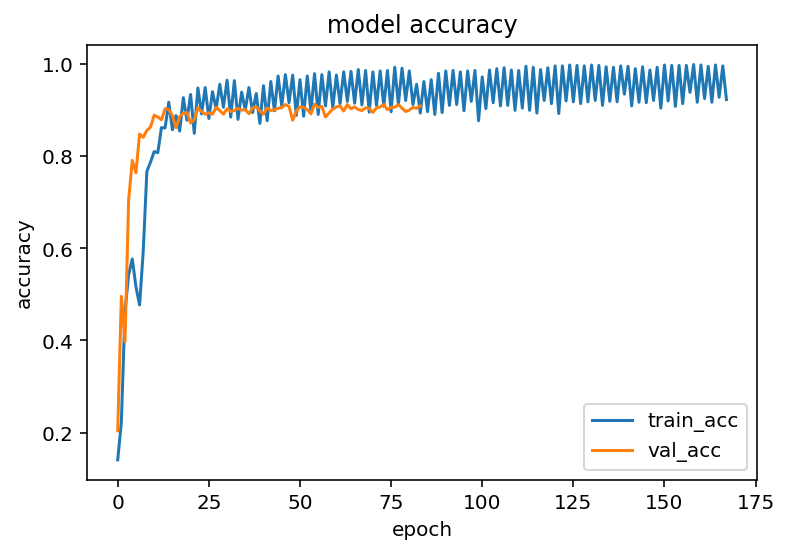

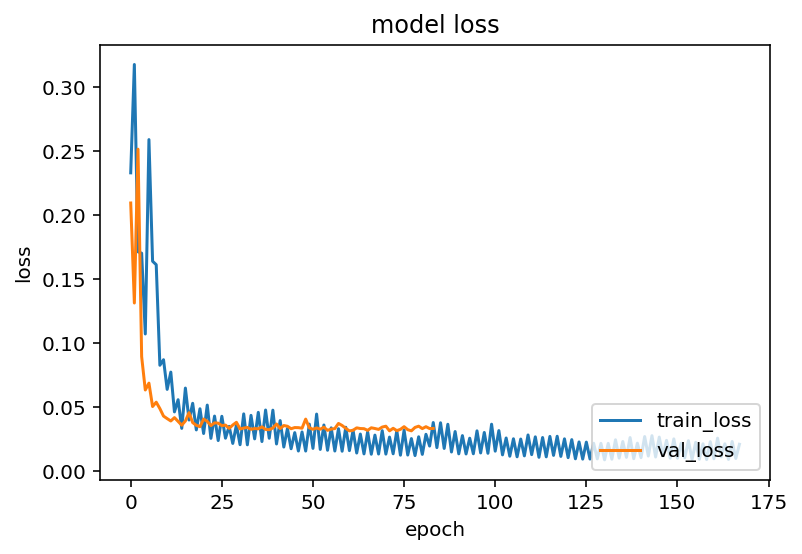

100%|██████████| 114/114 [00:11<00:00, 10.01it/s]


In [75]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ratio_pl = 1.0 # ratio of train:pseudo
hard = False
ex_name = 'baseline_distill'
trial_times = 10

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results_distill = {}
results_distill['test_acc'] = np.empty((trial_times))
results_distill['test_loss'] = np.empty((trial_times))
results_distill['unlabeled_acc'] = np.empty((trial_times))
results_distill['unlabeled_loss'] = np.empty((trial_times))
for i in range(trial_times):
    main_train_dataset = MNISTDataset(X_train, y_train, transform)
    main_train_loader = torch.utils.data.DataLoader(
        main_train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    sub_train_dataset = MNISTDataset(X_unlabeled, y_pseudo, transform)
    sub_train_loader = torch.utils.data.DataLoader(
        sub_train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_dataset = MNISTDataset(X_unlabeled, y_unlabeled, transform)
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, main_train_loader, sub_train_loader, criterion, optimizer, tracker, T=1.4)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results_distill['test_acc'][i], results_distill['test_loss'][i] = _test(model, test_loader, criterion)
    results_distill['unlabeled_acc'][i], results_distill['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion, unlabeled=True)

In [76]:
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_distill['test_acc']),
    np.std(results_distill['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results_distill['test_loss']),
    np.std(results_distill['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_distill['unlabeled_acc']),
    np.std(results_distill['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results_distill['unlabeled_loss']),
    np.std(results_distill['unlabeled_loss'])
))

[2017-12-07 23:22:42,375 INFO] Test Accuracy: 0.9223 ± 0.0041
[2017-12-07 23:22:42,380 INFO] Test Loss: 0.0292 ± 0.0012

[2017-12-07 23:22:42,385 INFO] Unlabeled Accuracy: 0.9147 ± 0.0051
[2017-12-07 23:22:42,391 INFO] Unlabeled Loss: 0.0312 ± 0.0013


In [ ]:
from scipy import stats

t, p = stats.ttest_rel(results['test_acc'], results_distill['test_acc'])
print( "p値 = %(p)s" %locals() )

In [ ]:
[2017-12-06 14:25:20,049 INFO] Test Accuracy: 0.9151 ± 0.0038
[2017-12-06 14:25:20,055 INFO] Test Loss: 0.0406 ± 0.0012

[2017-12-06 14:25:20,056 INFO] Unlabeled Accuracy: 0.9094 ± 0.0032
[2017-12-06 14:25:20,058 INFO] Unlabeled Loss: 0.0418 ± 0.0012